# Setup

### Load packages

In [3]:

import os
import glob

project_dir = "/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons"
#project_dir = "/standard/vol328/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/"
#project_dir ="/Users/zqn7td/Desktop/9samples_cellstate/"

os.chdir("/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts")

In [2]:
##Import packages


import anndata as ad
import scimap as sm
import importlib

import scanpy as sp
import pandas as pd
import numpy as np
import napari as napari
import math
import seaborn as sns
import itertools

from scipy import stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, leaves_list
from scipy.spatial.distance import pdist
from matplotlib.colors import Normalize

import hetmel as hm

Running SCIMAP  2.2.11


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [186]:
os.chdir('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts')
importlib.reload(hm)

<module 'hetmel' from '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py'>

### Set up files, directories, variables

Set and go to project directory 

## Set Case number here

In [105]:
case_numbers = [
    "Case2-8_nucleus",
    "Case2-8_merged",
    "Case2-8_filtered"
]
#"Case3-9",

phenotype = pd.read_csv(os.path.join(project_dir, '20251002_phenotyping_workflow_fullpanel.csv'))

In [197]:
adata_list[2].layers['log1p_raw']

array([[8.16446934, 5.35745821, 4.40671925, ..., 6.81707341, 5.73617452,
        3.52736727],
       [8.69332409, 6.45637482, 4.92475034, ..., 7.478011  , 5.62192526,
        4.02535169],
       [7.62895633, 5.43248714, 4.75723795, ..., 6.59898279, 5.63412945,
        3.43433777],
       ...,
       [7.43988828, 0.86710049, 1.58514522, ..., 6.80731597, 2.21920348,
        4.57471098],
       [8.46516485, 1.2039728 , 1.56123581, ..., 7.809215  , 2.35603293,
        2.23569086],
       [7.91713058, 1.14306405, 2.41021576, ..., 7.272714  , 2.7275557 ,
        3.07856828]])

In [5]:
feature_dir = os.path.join(project_dir, 'feature-extraction')
all_feature_files = glob.glob(os.path.join(feature_dir, '*.csv'))

feature_table_paths = {}

for case_number in case_numbers:
    # Find all files that contain the case_number in their name
    matches = [f for f in all_feature_files if case_number in os.path.basename(f)]
    if matches:
        # Take up to 3 matches per case_number
        feature_table_paths[case_number] = matches[:3]
        print(f"Found {len(matches[:3])} feature extraction files for {case_number}:")
        for m in matches[:3]:
            print(f"  {m}")
    else:
        feature_table_paths[case_number] = []
        print(f"No feature extraction file found for {case_number}")

Found 1 feature extraction files for Case2-8_nucleus:
  /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_nucleus.csv
Found 1 feature extraction files for Case2-8_merged:
  /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_merged.csv
Found 1 feature extraction files for Case2-8_filtered:
  /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_filtered.csv


In [144]:
import pandas as pd
import numpy as np

# Get file paths for nucleus and merged
nucleus_path = feature_table_paths["Case2-8_nucleus"][0]
merged_path = feature_table_paths["Case2-8_merged"][0]

# Read CSVs
df_nucleus = pd.read_csv(nucleus_path, index_col=0)
df_merged = pd.read_csv(merged_path, index_col=0)

# Compare DataFrames
if df_nucleus.equals(df_merged):
    print("nucleus.csv and merged.csv are exactly the same.")
else:
    # For numerical data, check if all values are close
    same = np.allclose(df_nucleus.values, df_merged.values)
    print(f"nucleus.csv and merged.csv are numerically {'the same' if same else 'different'}.")

    # Optionally, show where they differ
    if not same:
        diff = (df_nucleus != df_merged)
        print("Differences found at these positions:")
        print(diff)

nucleus.csv and merged.csv are numerically the same.


In [6]:
feature_table_paths

{'Case2-8_nucleus': ['/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_nucleus.csv'],
 'Case2-8_merged': ['/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_merged.csv'],
 'Case2-8_filtered': ['/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_filtered.csv']}

In [17]:
# Loop through each case and its feature extraction files
for case_number, file_list in feature_table_paths.items():
    if file_list:
        for feature_table_path in file_list:
            

            print(f"Processing {case_number} ({suffix}): {feature_table_path}")
            adata = sm.pp.mcmicro_to_scimap(feature_table_path)
            # make log1p raw layer
            adata.layers["log1p_raw"] = np.log1p(adata.raw.X)
            # clean imageid
            adata.obs['imageid'] = (
                adata.obs['imageid']
                .astype(str)
                .str.replace('_feature_extraction$', '', regex=True)
            )
            # Save with case number and suffix
            save_path = os.path.join(
                project_dir,
                'raw_adata',
                f"{case_number}_raw.h5ad"
            )
            os.makedirs(os.path.dirname(save_path), exist_ok=True) 
            adata.write_h5ad(save_path)
            print(f"Saved: {save_path}")
    else:
        print(f"Skipping {case_number}: No feature extraction file found.")

Processing Case2-8_nucleus (filtered): /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_nucleus.csv
Loading Case2-8_nucleus.csv
Saved: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/raw_adata/Case2-8_nucleus_raw.h5ad
Processing Case2-8_merged (filtered): /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_merged.csv
Loading Case2-8_merged.csv
Saved: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/raw_adata/Case2-8_merged_raw.h5ad
Processing Case2-8_filtered (filtered): /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/feature-extraction/Case2-8_filtered.csv
Loading Case2-8_filtered.csv
Saved: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/2025100

In [18]:
adata_list[0].obs['imageid']

IndexError: list index out of range

## Gating for individual images 

### Set case_number here

In [89]:
case_number ="Case9-7_R2"

In [90]:
adata = ad.read_h5ad(os.path.join(project_dir, 'raw_adata', f'{case_number}_raw.h5ad'))
adata.obs['imageid']

Case9-7_R2_feature_extraction_1         Case9-7
Case9-7_R2_feature_extraction_2         Case9-7
Case9-7_R2_feature_extraction_3         Case9-7
Case9-7_R2_feature_extraction_4         Case9-7
Case9-7_R2_feature_extraction_5         Case9-7
                                         ...   
Case9-7_R2_feature_extraction_160571    Case9-7
Case9-7_R2_feature_extraction_160572    Case9-7
Case9-7_R2_feature_extraction_160573    Case9-7
Case9-7_R2_feature_extraction_160574    Case9-7
Case9-7_R2_feature_extraction_160575    Case9-7
Name: imageid, Length: 160575, dtype: category
Categories (1, object): ['Case9-7']

## Check pixel distribution 

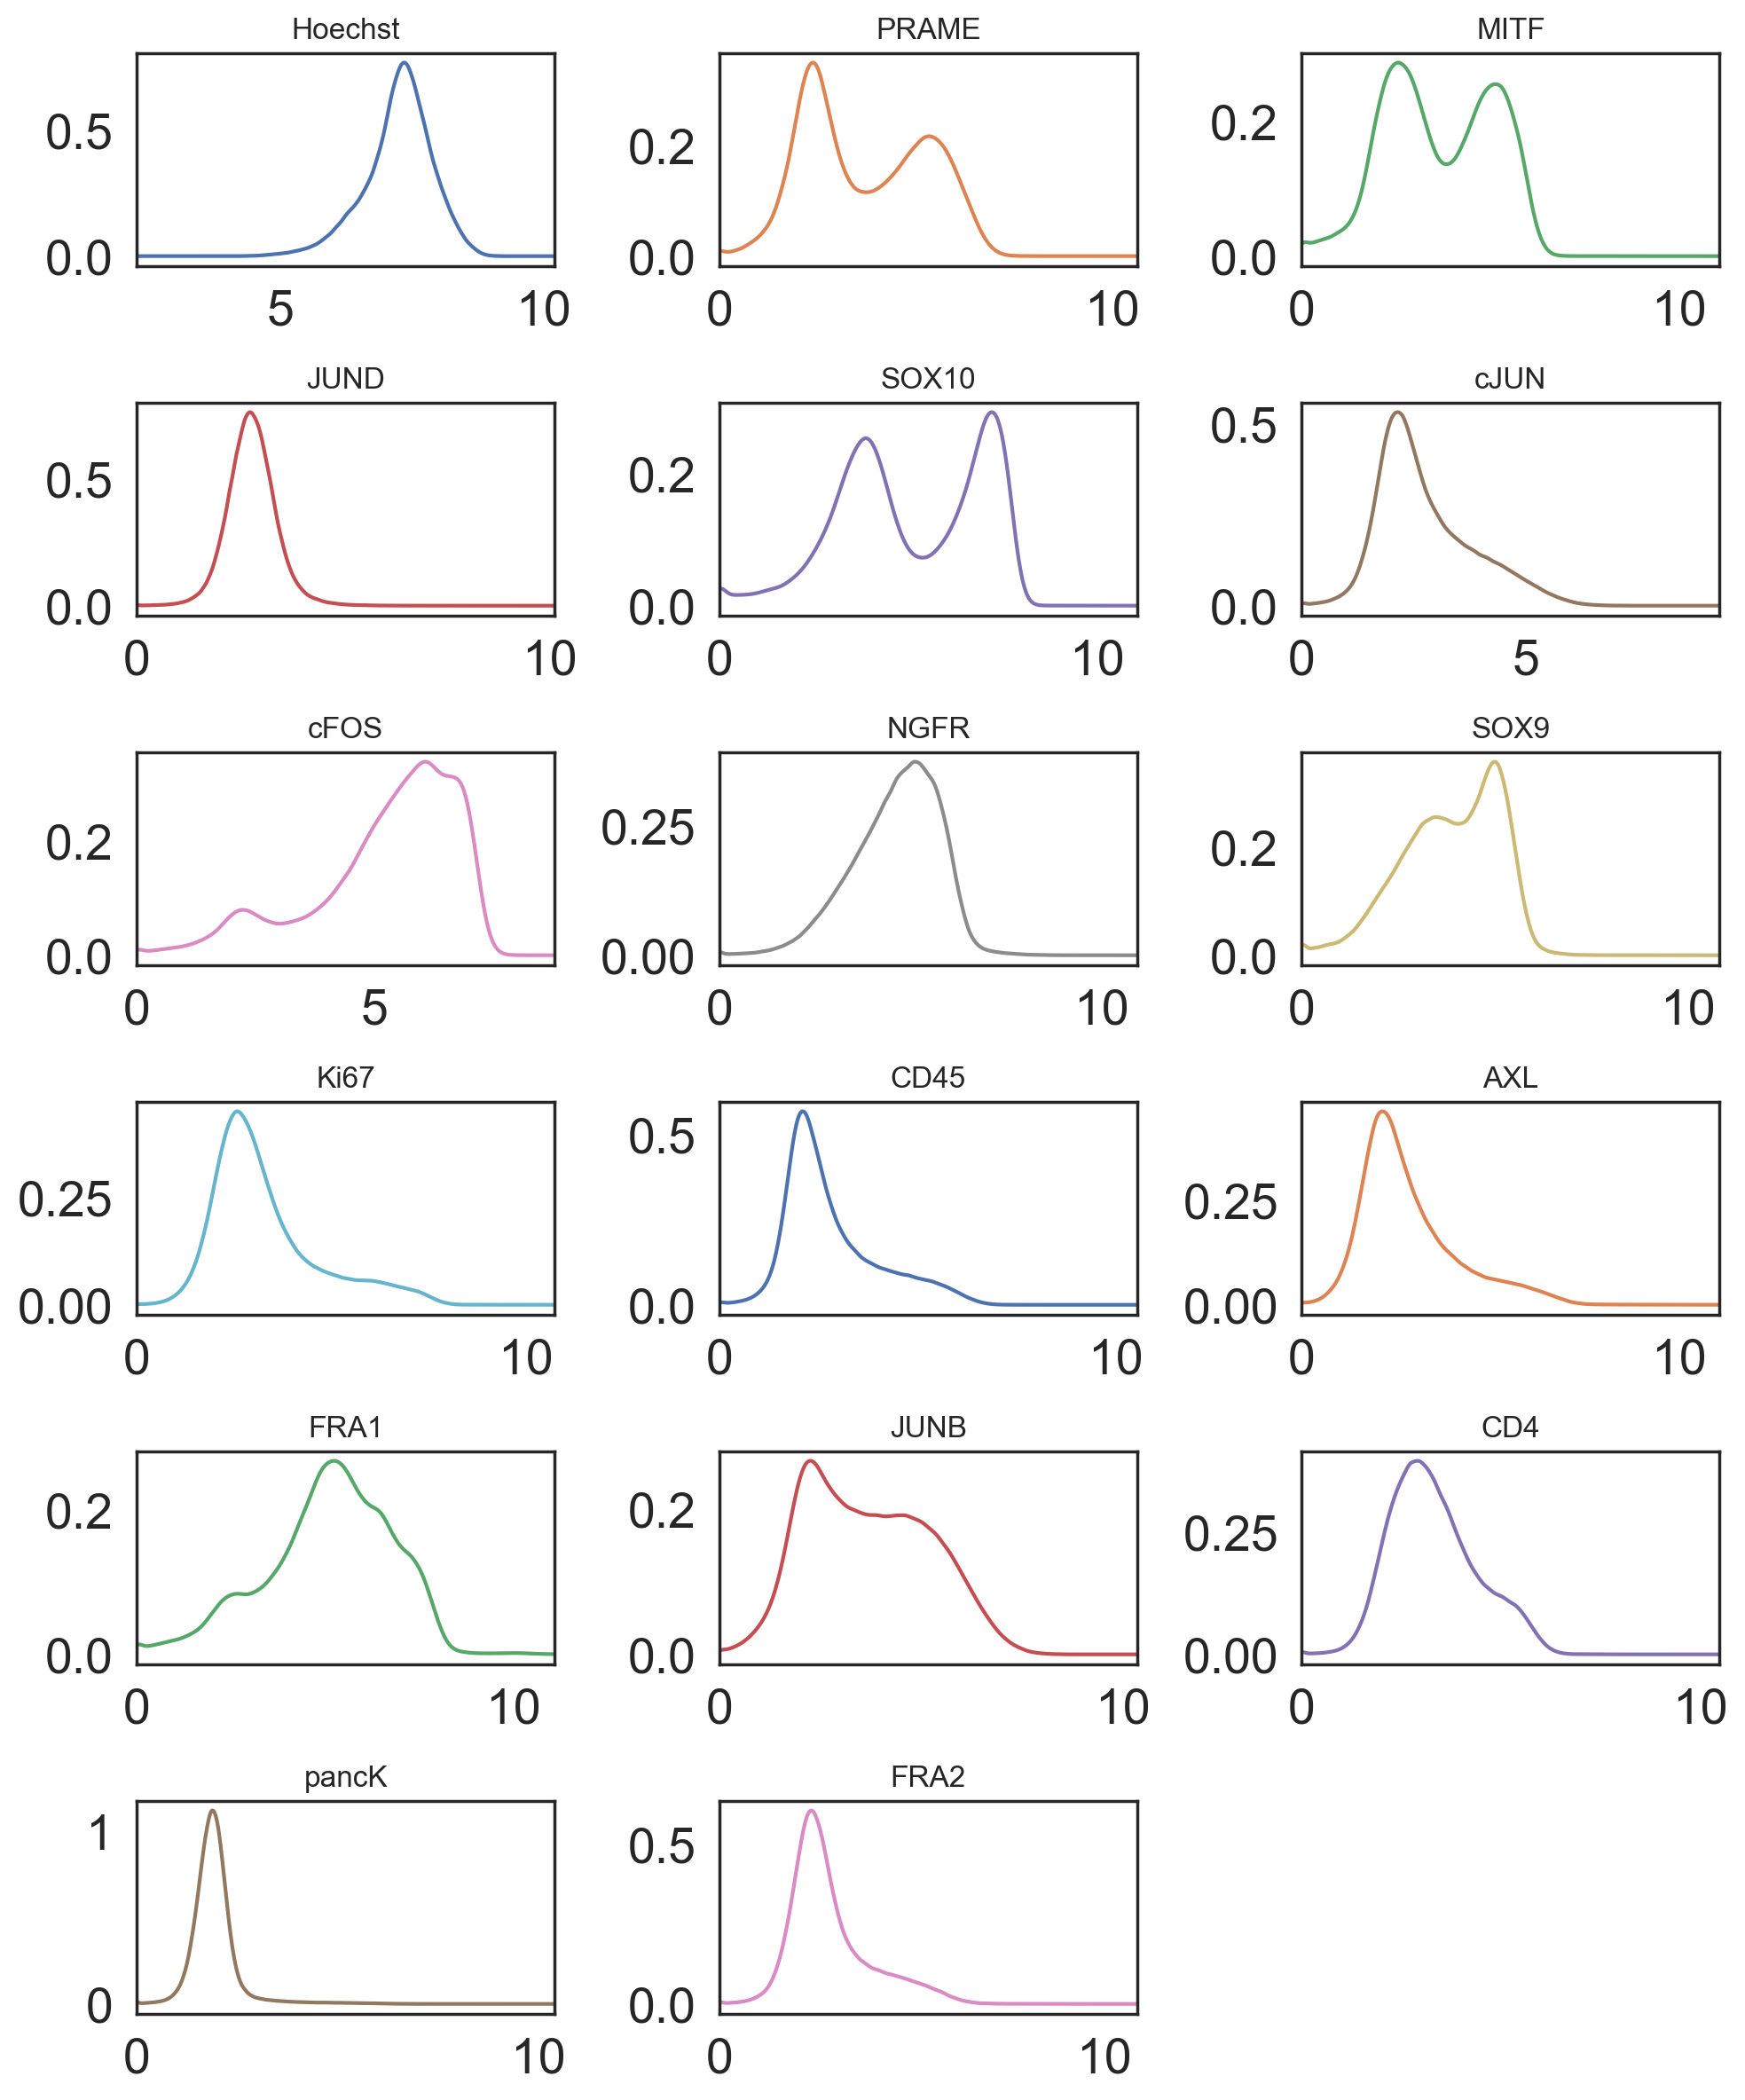

In [69]:
hm.distPlot(adata, layer='log1p_raw',figsize=(10,12),ncols=3, fontsize=20)

## Gating

Find image file. Use final rolling ball background subtracted version

In [91]:
# Search recursively for the ome.tif file containing the case_number in its name  
image_search_pattern = os.path.join(project_dir, case_number, f'*{case_number}*rb*final.ome.tif')
image_files = glob.glob(image_search_pattern, recursive=True)

if image_files:
    image_path = image_files[0]
    print(f"image_path for {case_number}: {image_path}")
else:
    image_path = None
    print(f"No image found for {case_number}")

image_path for Case9-7_R2: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/Case9-7_R2/Case9-7_R2_bgsub_rb_15_final.ome.tif


read in image file

In [23]:
from tifffile import imread
img_data = imread(image_path)
print(img_data.shape) 

(17, 3000, 9325)


In [71]:
image_path

'/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/Case8-9_R1/Case8-9_R1_bgsub_rb_15_final.ome.tif'

Use napari to identify gates for thresholding positive vs negative expression of markers. Gates are used for binarized phenotyping and also for normalization of markers that are expressed on a continuos distribution

In [ ]:
sm.pl.napariGater (image_path, adata, )

/var/folders/vb/f8_hhkls73qf5938jf5w6rk9dds1_2/T/ipykernel_27495/2199281803.py:1: UserWarning:

NOTE: napariGater() is currently in beta testing. If you encounter any issues, please report them at: https://github.com/labsyspharm/scimap/issues



Initializing...
Initializing gates with GMM...


Loading image data...
Calculating contrast settings...


Saved contrast settings for Case9-7 with 17 channels
Initialization completed in 8.52 seconds
Opening napari viewer...
Napari viewer initialized in 10.53 seconds


In [78]:
adata.uns['gates']

,Case8-9
Hoechst,7.414495
PRAME,4.400000
MITF,4.000000
JUND,3.600000
SOX10,6.000000
cJUN,3.250000
cFOS,4.360000
NGFR,5.110000
SOX9,4.300000
Ki67,4.200000


Save gates to csv

In [88]:
gates_df = adata.uns['gates']
gates_path=os.path.join(project_dir,case_number, f"{case_number}_gates.csv")
gates_df.to_csv((gates_path), index=True)
print(f"Saved gates to {gates_path}")

Saved gates to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/Case10-3_R1/Case10-3_R1_gates.csv


## Generate list containing normalized adata of all cases

find paths to gates.csv files 

In [19]:

gate_file_paths = {}

for case_number in case_numbers:
    # Search for gates.csv inside the case-specific subdirectory
    search_path = os.path.join(project_dir, '*gates.csv')
    matches = glob.glob(search_path)
    if matches:
        gate_file_paths[case_number] = matches[0]  # Take the first match
        print(f"Found for {case_number}: {matches[0]}")
    else:
        gate_file_paths[case_number] = None
        print(f"No gates.csv file found for {case_number}")

Found for Case2-8_nucleus: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv
Found for Case2-8_merged: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv
Found for Case2-8_filtered: /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv


In [10]:
gate_file_paths

{'Case2-8_nucleus': '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv',
 'Case2-8_merged': '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv',
 'Case2-8_filtered': '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_full_gates.csv'}

Loop through adata for each case, normalize the adata to that case's gate values, and append normalized data to a list

In [20]:
adata_list = []
suffixes = ["nucleus","merged", "filtered", ]  # Add any suffixes you expect
for case_number in case_numbers:
    if gate_file_paths[case_number] is not None:
        print(f"Reading in raw adata for {case_number}")
        
        adata_path = os.path.join(project_dir, 'raw_adata', f'{case_number}_raw.h5ad')
        if os.path.exists(adata_path):
            adata = ad.read_h5ad(adata_path)
            print(f"Loaded {adata_path}")
            # ...rest of your normalization code...
            marker_gates = pd.read_csv(os.path.join(project_dir, 'Case2-8_full_gates.csv'), header=[0], index_col=[0])
            adata.uns['gates'] = marker_gates
            hm.normalize_to_gates(adata)
            adata.layers['log_background_normalized_zeroed'] = adata.layers['log_background_normalized'].copy()
            adata.layers['log_background_normalized_zeroed'][adata.layers['log_background_normalized_zeroed'] < 0] = 0
            adata.obs['TissueID'] = adata.obs['imageid'].str.split('_').str[0]
            adata_list.append(adata)
        else:
            print(f"File not found: {adata_path}")
    else:
        print(f"Skipping {case_number}: No gates.csv file found, cannot normalize and combine")
        


Reading in raw adata for Case2-8_nucleus
Loaded /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/raw_adata/Case2-8_nucleus_raw.h5ad
Subtracting the following gate values from each marker:
  Hoechst_1: 8.064459490587334
  PRAME: 3.4
  MITF: 3.28
  JUND: 4.1
  SOX10: 5.54
  cJUN: 4.06
  cFOS: 4.29
  NGFR: 5.42
  SOX9: 4.11
  Ki67: 4.58
  CD45: 3.85
  AXL: 5.54
  FRA1: 4.08
  Hoechst_6: 7.748817289428954
  JUNB: 3.92
  CD4: 4.27
  pancK: 3.7
  FRA2: 4.37
  CD163: 4.7
  alphaSMA: 5.4
  CD8: 4.5
  CD19: 5.0
  FAP: 4.8
  Hoechst_11: 7.184034680504377
  CD31: 4.19
  PDGFRBeta: 4.77
  pSTAT1: 3.1
  FOXP3: 3.4
  CD68: 3.86
  BRAFV600E: 3.0
  phospho-p38: 3.8
  Hoechst_16: 7.243353474482907
  anti-Melanoma: 3.7
  phospho-p44: 3.5988616794406245
Background normalization complete. Layer 'log_background_normalized' added.
Reading in raw adata for Case2-8_merged
Loaded /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002

In [21]:
adata_list

[AnnData object with n_obs × n_vars = 674801 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'TissueID'
     uns: 'all_markers', 'gates'
     layers: 'log', 'log1p_raw', 'log_background_normalized', 'log_background_normalized_zeroed',
 AnnData object with n_obs × n_vars = 674801 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'TissueID'
     uns: 'all_markers', 'gates'
     layers: 'log', 'log1p_raw', 'log_background_normalized', 'log_background_normalized_zeroed',
 AnnData object with n_obs × n_vars = 548372 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'TissueID'
     uns: 'all_markers', 'gates'
     layers: 'log', 'log1p_raw', 'log_background

## add ROIs


loop through each adata in adata_list and add ROIs using napari

In [ ]:
for adata in adata_list:
    case_number= adata.obs['imageid'].unique()[0]
    print(f"Adding ROI image for {case_number}")
    image_search_pattern = os.path.join(project_dir, case_number, f'*{case_number}*rb*final.ome.tif')
    image_files = glob.glob(image_search_pattern, recursive=True)
    
    if image_files:
        image_path = image_files[0]
        print(f"image_path for {case_number}: {image_path}")
    else:
        image_path = None
        print(f"No image found for {case_number}")
        
    sm.pl.addROI_image(image_path, adata, markers=['Hoechst','MITF','SOX10','PRAME','NGFR','SOX9','cFOS','cJUN','CD45'])
    print(adata.obs['ROI'].value_counts(dropna=False))
    ROIs = adata.obs['ROI']
    print(f"Saving ROIs for {case_number}")
    ROIs.to_csv(os.path.join(project_dir, case_number,f'{case_number}_ROIs.csv'), index=True)
        
        

if you need to, load in ROI labels from csv

In [355]:
for adata in adata_list:
    case_number=str(adata.obs['imageid'].unique()[0])
    ROIs= pd.read_csv(os.path.join(project_dir, case_number,f'{case_number}_ROIs.csv'), index_col=0)
    adata.obs['ROI'] = ROIs

Read in adata_list if necessary

In [244]:
adata_list= []
for case in case_numbers:
    adata_path = os.path.join(project_dir, 'processed_adata', f'{case}_adata.h5ad')
    adata = ad.read_h5ad(adata_path)
    
    adata_list.append(adata)

extracting gates from adata_list

In [8]:
adata_list= []
for case in case_numbers:
    adata_path = os.path.join(project_dir, 'processed_adata', f'{case}_adata.h5ad')
    adata = ad.read_h5ad(adata_path)
    
    adata_list.append(adata)

In [10]:
adata_list[1].uns['gates']

,Case2-8
markers,
AXL,5.54000
CD4,4.47000
CD45,3.91000
FRA1,4.48000
FRA2,4.47000
Hoechst,8.00655
JUNB,4.02000
JUND,3.95000
Ki67,4.58000


In [11]:
# ...existing code...

for adata, case in zip(adata_list, case_numbers):
    gates_df = adata.uns.get('gates')
    if gates_df is not None:
        gates_dir = os.path.join(project_dir,'gates')
        os.makedirs(gates_dir, exist_ok=True)
        gates_path = os.path.join(gates_dir, f'{case}_gates.csv')
        gates_df.to_csv(gates_path, index=True)
        print(f"Saved gates for {case} to {gates_path}")
    else:
        print(f"No gates found for {case}")

#

Saved gates for Case1-31 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case1-31_gates.csv
Saved gates for Case2-8 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case2-8_gates.csv
Saved gates for Case4-5_R1 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case4-5_R1_gates.csv
Saved gates for Case4-5_R2 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case4-5_R2_gates.csv
Saved gates for Case7-10 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case7-10_gates.csv
Saved gates for Case8-9_R1 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250707_9samples_cellstate/gates/Case8-9_R1_gates.csv
Saved gates for Case8-9_R2 to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_

In [22]:
#copy adata
reference_adata_path = "/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/Case2-8_old_adata.h5ad"
reference_adata = ad.read_h5ad(reference_adata_path)

In [145]:
adata_list[2].obs['phenotype']

Case2-8_filtered_163             Tumor cell
Case2-8_filtered_165             Tumor cell
Case2-8_filtered_173             Tumor cell
Case2-8_filtered_174             Tumor cell
Case2-8_filtered_181             Tumor cell
                                 ...       
Case2-8_filtered_674779          Fibroblast
Case2-8_filtered_674780    Cytotoxic T cell
Case2-8_filtered_674784        Keratinocyte
Case2-8_filtered_674786          Fibroblast
Case2-8_filtered_674792          Fibroblast
Name: phenotype, Length: 548372, dtype: object

In [59]:
reference_adata.obs['ROI'].value_counts()

ROI
Tumor_Case2-8    517557
Other            157244
Name: count, dtype: int64

In [62]:
import re

def extract_number(idx):
    # Extract the trailing number from the index string
    match = re.search(r'(\d+)$', str(idx))
    return match.group(1) if match else None

# Build a mapping from number to ROI in reference_adata
reference_numbers = reference_adata.obs.index.map(extract_number)
roi_map = dict(zip(reference_numbers, reference_adata.obs['ROI']))

for adata in adata_list:
    adata_numbers = adata.obs.index.map(extract_number)
    adata.obs['ROI'] = [roi_map.get(num, None) for num in adata_numbers]

In [ ]:
for adata in range(adata_list)
    # Only copy ROI column for matching indices
    adata.obs['ROI'] = reference_adata.obs['ROI'].reindex(adata.obs.index)

In [64]:
adata_list[1].obs['phenotype'].value_counts()

phenotype
Unknown                                 161006
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-    143337
Fibroblast                              115123
Keratinocyte                             50010
Immune cell                              42315
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-     30002
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-     13384
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-     11977
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-     11494
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-     10251
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-     10101
Endothelial Cell                          9833
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-      8260
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-      6894
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-      6678
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-      6198
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-      5396
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-      4112
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-      3693
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-      3298
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-      3116
MIT

## Phenotyping

Loop through adata list, rescale data according to gates, and run phenotyping. Data is shifted so the gate is the new 0; positive values will be phenotyped as positive and negative values will be phenotyped as negative. If it's running into an error where it can't find gates, check adata.uns['gates']. Column name for the gates should match imageid

In [106]:
for i in range(len(adata_list)):
    adata = adata_list[i]

    # Validate gate format if necessary (optional safety check)
    gate = adata.uns.get("gates")
    if gate is not None and gate.columns[0] != "gates":
        gate = gate.rename(columns={gate.columns[0]: "gates"}).reset_index().rename(columns={"index": "markers"})
        adata.uns["gates"] = gate

    sm.pp.rescale(adata, gate=adata.uns['gates'])

    adata = sm.tl.phenotype_cells(adata, phenotype=phenotype, label="phenotype")

    adata_list[i] = adata  # store back if needed

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:126: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: Case2-8_nucleus
Scaling Hoechst_1 (gate: 8.064)
Scaling PRAME (gate: 3.400)
Scaling MITF (gate: 3.280)
Scaling JUND (gate: 4.100)
Scaling SOX10 (gate: 5.540)
Scaling cJUN (gate: 4.060)
Scaling cFOS (gate: 4.290)
Scaling NGFR (gate: 5.420)
Scaling SOX9 (gate: 4.110)
Scaling Ki67 (gate: 4.580)
Scaling CD45 (gate: 3.850)
Scaling AXL (gate: 5.540)
Scaling FRA1 (gate: 4.080)
Scaling Hoechst_6 (gate: 7.749)
Scaling JUNB (gate: 3.920)
Scaling CD4 (gate: 4.270)
Scaling pancK (gate: 3.700)
Scaling FRA2 (gate: 4.370)
Scaling CD163 (gate: 4.700)
Scaling alphaSMA (gate: 5.400)
Scaling CD8 (gate: 4.500)
Scaling CD19 (gate: 5.000)
Scaling FAP (gate: 4.800)
Scaling Hoechst_11 (gate: 7.184)
Scaling CD31 (gate: 4.190)
Scaling PDGFRBeta (gate: 4.770)
Scaling pSTAT1 (gate: 3.100)
Scaling FOXP3 (gate: 3.400)
Scaling CD68 (gate: 3.860)
Scaling BRAFV600E (gate: 3.000)
Scaling phospho-p38 (gate: 3.800)
Scaling Hoechst_16 (gate: 7.243)
Scaling anti-Melanoma (gate: 3.700)
Scaling phospho-p44 (g

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping Fibroblast
Phenotyping Endothelial cell


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping Keratinocyte
-- Subsetting Immune cell
Phenotyping Cytotoxic T cell
Phenotyping Helper T cell
Phenotyping B cell
Phenotyping Macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

-- Subsetting Helper T cell
Phenotyping T-Regulatory cell


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Macrophage
Phenotyping Pro-tumor macrophage
Phenotyping Inflammatory macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Tumor cell
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Consolidating the phenotypes across all groups


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:126: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: Case2-8_merged
Scaling Hoechst_1 (gate: 8.064)
Scaling PRAME (gate: 3.400)
Scaling MITF (gate: 3.280)
Scaling JUND (gate: 4.100)
Scaling SOX10 (gate: 5.540)
Scaling cJUN (gate: 4.060)
Scaling cFOS (gate: 4.290)
Scaling NGFR (gate: 5.420)
Scaling SOX9 (gate: 4.110)
Scaling Ki67 (gate: 4.580)
Scaling CD45 (gate: 3.850)
Scaling AXL (gate: 5.540)
Scaling FRA1 (gate: 4.080)
Scaling Hoechst_6 (gate: 7.749)
Scaling JUNB (gate: 3.920)
Scaling CD4 (gate: 4.270)
Scaling pancK (gate: 3.700)
Scaling FRA2 (gate: 4.370)
Scaling CD163 (gate: 4.700)
Scaling alphaSMA (gate: 5.400)
Scaling CD8 (gate: 4.500)
Scaling CD19 (gate: 5.000)
Scaling FAP (gate: 4.800)
Scaling Hoechst_11 (gate: 7.184)
Scaling CD31 (gate: 4.190)
Scaling PDGFRBeta (gate: 4.770)
Scaling pSTAT1 (gate: 3.100)
Scaling FOXP3 (gate: 3.400)
Scaling CD68 (gate: 3.860)
Scaling BRAFV600E (gate: 3.000)
Scaling phospho-p38 (gate: 3.800)
Scaling Hoechst_16 (gate: 7.243)
Scaling anti-Melanoma (gate: 3.700)
Scaling phospho-p44 (ga

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping Endothelial cell
Phenotyping Keratinocyte


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Immune cell
Phenotyping Cytotoxic T cell
Phenotyping Helper T cell
Phenotyping B cell
Phenotyping Macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

-- Subsetting Helper T cell
Phenotyping T-Regulatory cell


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Macrophage
Phenotyping Pro-tumor macrophage
Phenotyping Inflammatory macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Tumor cell
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Consolidating the phenotypes across all groups


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:126: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: Case2-8_filtered
Scaling Hoechst_1 (gate: 8.064)
Scaling PRAME (gate: 3.400)
Scaling MITF (gate: 3.280)
Scaling JUND (gate: 4.100)
Scaling SOX10 (gate: 5.540)
Scaling cJUN (gate: 4.060)
Scaling cFOS (gate: 4.290)
Scaling NGFR (gate: 5.420)
Scaling SOX9 (gate: 4.110)
Scaling Ki67 (gate: 4.580)
Scaling CD45 (gate: 3.850)
Scaling AXL (gate: 5.540)
Scaling FRA1 (gate: 4.080)
Scaling Hoechst_6 (gate: 7.749)
Scaling JUNB (gate: 3.920)
Scaling CD4 (gate: 4.270)
Scaling pancK (gate: 3.700)
Scaling FRA2 (gate: 4.370)
Scaling CD163 (gate: 4.700)
Scaling alphaSMA (gate: 5.400)
Scaling CD8 (gate: 4.500)
Scaling CD19 (gate: 5.000)
Scaling FAP (gate: 4.800)
Scaling Hoechst_11 (gate: 7.184)
Scaling CD31 (gate: 4.190)
Scaling PDGFRBeta (gate: 4.770)
Scaling pSTAT1 (gate: 3.100)
Scaling FOXP3 (gate: 3.400)
Scaling CD68 (gate: 3.860)
Scaling BRAFV600E (gate: 3.000)
Scaling phospho-p38 (gate: 3.800)
Scaling Hoechst_16 (gate: 7.243)
Scaling anti-Melanoma (gate: 3.700)
Scaling phospho-p44 (

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Phenotyping Endothelial cell
Phenotyping Keratinocyte


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Immune cell
Phenotyping Cytotoxic T cell
Phenotyping Helper T cell
Phenotyping B cell
Phenotyping Macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

-- Subsetting Helper T cell
Phenotyping T-Regulatory cell


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Macrophage
Phenotyping Pro-tumor macrophage
Phenotyping Inflammatory macrophage


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- Subsetting Tumor cell
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL-
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL-
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL-
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL-
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL-


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9- AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR- SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME- NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL+
Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10- PRAME- NGFR- SOX9- AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL+
Phenotyping MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Consolidating the phenotypes across all groups


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [107]:
adata_list[2].obs['ROI'].value_counts()

ROI
Tumor_Case2-8    426964
Other            121408
Name: count, dtype: int64

Replace all "Tumor cell" phenotypes with "Unknown"

In [101]:
for i in range(len(adata_list)):
    adata = adata_list[i]
    adata.obs['phenotype'] = adata.obs['phenotype'].replace('Tumor cell', 'Unknown')


Assign cell phenotype category. ie. Identify tumor cells vs TME 

In [187]:
for i in range(len(adata_list)):
    adata = adata_list[i]
    adata.obs['phenotype_category'] = adata.obs['phenotype'].apply(hm.categorize_phenotype)

In [112]:
adata_list[0].obs['phenotype_category'].value_counts()

phenotype_category
Tumor    296514
Other    211016
TME      167271
Name: count, dtype: int64

In [110]:
print(adata_list[0].obs['phenotype'].value_counts())

phenotype
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-    143337
Fibroblast                              115123
Unknown                                  84578
Tumor cell                               76428
Keratinocyte                             50010
                                         ...  
MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL+        31
MITF- SOX10+ PRAME- NGFR+ SOX9- AXL+        23
MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL+        20
MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL+        19
MITF- SOX10- PRAME- NGFR- SOX9+ AXL+         1
Name: count, Length: 68, dtype: int64


In [37]:
for adata, case_number in zip(adata_list, case_numbers):
    adata.obs['imageid'] = case_number

In [40]:
adata_list[2].obs['imageid']

Case2-8_filtered_163       Case2-8_filtered
Case2-8_filtered_165       Case2-8_filtered
Case2-8_filtered_173       Case2-8_filtered
Case2-8_filtered_174       Case2-8_filtered
Case2-8_filtered_181       Case2-8_filtered
                                 ...       
Case2-8_filtered_674779    Case2-8_filtered
Case2-8_filtered_674780    Case2-8_filtered
Case2-8_filtered_674784    Case2-8_filtered
Case2-8_filtered_674786    Case2-8_filtered
Case2-8_filtered_674792    Case2-8_filtered
Name: imageid, Length: 548372, dtype: object

Save each case's adata individually

In [65]:
for adata in adata_list:
    adata.write_h5ad(os.path.join(project_dir,'processed_adata',f"{adata.obs['imageid'].unique()[0]}_adata.h5ad"))

In [143]:
print("adata_list[0] PDGFRBeta log1p_raw mean:", np.mean(adata_list[0].layers["log1p_raw"][:, adata_list[0].var_names.get_loc("NGFR")]))
print("adata_list[1] PDGFRBeta log1p_raw mean:", np.mean(adata_list[1].layers["log1p_raw"][:, adata_list[1].var_names.get_loc("NGFR")]))

adata_list[0] PDGFRBeta log1p_raw mean: 3.9032827001392496
adata_list[1] PDGFRBeta log1p_raw mean: 3.9032827001392496


In [140]:
print(adata_list[0].layers["log1p_raw"][:5, :5])
print(adata_list[1].layers["log1p_raw"][:5, :5])

[[8.78620096 3.92540249 0.         1.04982212 4.69078603]
 [7.59611442 3.5958539  3.04856693 3.75075486 2.54009307]
 [8.52460317 4.11700259 1.32175584 0.98861139 4.54793824]
 [5.8993991  0.         1.99655388 1.68246305 0.27625338]
 [9.23458121 4.60245044 0.         0.35048297 5.2512387 ]]
[[8.78620096 3.92540249 0.         1.04982212 4.69078603]
 [7.59611442 3.5958539  3.04856693 3.75075486 2.54009307]
 [8.52460317 4.11700259 1.32175584 0.98861139 4.54793824]
 [5.8993991  0.         1.99655388 1.68246305 0.27625338]
 [9.23458121 4.60245044 0.         0.35048297 5.2512387 ]]


## Combine normalized adata into one big adata

In [66]:
combined_adata = ad.concat(
    adata_list,
    join='outer',
    index_unique='-')
combined_adata.obs['imageid'].unique()
combined_adata.uns['all_markers'] = combined_adata.var.index.tolist()

In [43]:
print(combined_adata.obs['imageid'].unique())
combined_adata

['Case2-8_nucleus', 'Case2-8_merged', 'Case2-8_filtered']
Categories (3, object): ['Case2-8_filtered', 'Case2-8_merged', 'Case2-8_nucleus']


AnnData object with n_obs × n_vars = 1897974 × 34
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'TissueID', 'phenotype', 'phenotype_category', 'ROI'
    uns: 'all_markers'
    layers: 'log', 'log1p_raw', 'log_background_normalized', 'log_background_normalized_zeroed'

In [56]:
combined_adata.obs['phenotype_category'].value_counts()

phenotype_category
Tumor    848484
Other    697469
TME      352021
Name: count, dtype: int64

In [53]:
combined_adata.obs['ROI'].unique()

[NaN]
Categories (2, object): ['Other', 'Tumor_Case2-8']

In [67]:
combined_adata.obs['ROI'].value_counts()

ROI
Tumor_Case2-8    1462078
Other             435896
Name: count, dtype: int64

Save combined adata

In [68]:
combined_adata.write_h5ad(os.path.join(project_dir, 'combined_adata.h5ad'))

In [52]:
tumor_adata.obs['ROI'].value_counts()

Series([], Name: count, dtype: int64)

In [69]:
#subset adata for cells with Tumor phenotype and Tumor ROI
tumor_adata = combined_adata[(combined_adata.obs['phenotype_category'] == 'Tumor') & (combined_adata.obs['ROI'].str.contains('Tumor', na=False, case=False))]
tumor_adata.obs['ROI'].value_counts()


ROI
Tumor_Case2-8    796455
Name: count, dtype: int64

In [70]:
tumor_adata.write(os.path.join(project_dir, "combined_tumor_adata_v1.h5ad"))

In [71]:
tumor_adata.obs['phenotype_category'].value_counts()

phenotype_category
Tumor    796455
Name: count, dtype: int64

In [130]:
#Marker subsets

AP1s = ['cFOS', 'FRA1','FRA2','cJUN','JUNB','JUND']
Diff_state_markers = ['MITF','SOX10','PRAME','SOX9','NGFR','AXL',]#'anti-Melanoma']
TME_markers = [
    'CD45', 'CD8', 'CD4', 'FOXP3', 'CD19', 'CD68', 'CD163', 'pSTAT1',
    'alphaSMA', 'FAP', 'CD31', 'pancK'
]

Combine nucleus, nuc_cyto, cytoring adata for one tumor

In [31]:
case_number = "Case2-8"
suffixes = ["nucleus", "nuc_cyto", "cytorings"]

adata_dict = {}
for suffix in suffixes:
    adata_path = os.path.join(project_dir, 'raw_adata', f"{case_number}_raw_{suffix}.h5ad")
    if os.path.exists(adata_path):
        adata = ad.read_h5ad(adata_path)
        adata.obs['segmentation_mask'] = suffix
        adata_dict[suffix] = adata
    else:
        print(f"Missing file: {adata_path}")

# Now you have three separate adata objects in adata_dict, each with .obs['segmentation_mask'] set

In [32]:
adata_dict

{'nucleus': AnnData object with n_obs × n_vars = 674801 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'segmentation_mask'
     uns: 'all_markers'
     layers: 'log', 'log1p_raw',
 'nuc_cyto': AnnData object with n_obs × n_vars = 674801 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'segmentation_mask'
     uns: 'all_markers'
     layers: 'log', 'log1p_raw',
 'cytorings': AnnData object with n_obs × n_vars = 674726 × 34
     obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'segmentation_mask'
     uns: 'all_markers'
     layers: 'log', 'log1p_raw'}

In [22]:
combined_adata = ad.concat(
    list(adata_dict.values()),
    join='outer',
    index_unique=None
)
print(combined_adata.obs['segmentation_mask'].value_counts())

segmentation_mask
nucleus      674801
nuc_cyto     674801
cytorings    674726
Name: count, dtype: int64


In [30]:
adata_dict['nucleus'].uns['all_markers']

array(['Hoechst_1', 'PRAME', 'MITF', 'JUND', 'SOX10', 'cJUN', 'cFOS',
       'NGFR', 'SOX9', 'Ki67', 'CD45', 'AXL', 'FRA1', 'Hoechst_6', 'JUNB',
       'CD4', 'pancK', 'FRA2', 'CD163', 'alphaSMA', 'CD8', 'CD19', 'FAP',
       'Hoechst_11', 'CD31', 'PDGFRBeta', 'pSTAT1', 'FOXP3', 'CD68',
       'BRAFV600E', 'phospho-p38', 'Hoechst_16', 'anti-Melanoma',
       'phospho-p44'], dtype=object)

In [77]:
combined_adata.obs['imageid'].unique()

['Case2-8_nucleus', 'Case2-8_merged', 'Case2-8_filtered']
Categories (3, object): ['Case2-8_filtered', 'Case2-8_merged', 'Case2-8_nucleus']

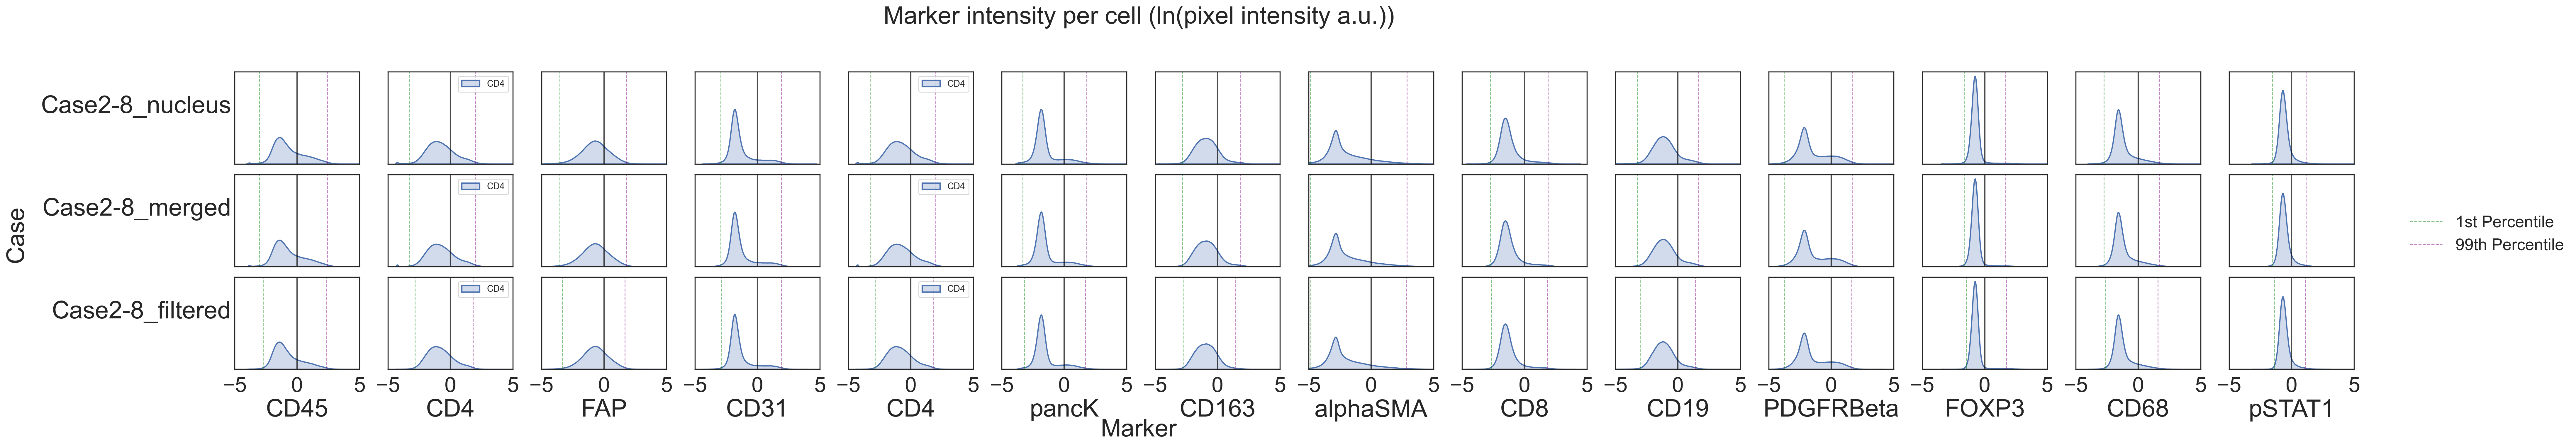

In [83]:
hm.distPlot3(combined_adata, layer='log_background_normalized', multiple_cases= True, plot_title='Marker intensity per cell (ln(pixel intensity a.u.))',
              markers=TME_markers, 
              figsize=(20,20), fontsize=30,scale_x1=-5, scale_x2=5, vline=0,)

Raw pixel distribution

In [233]:
combined_adata

AnnData object with n_obs × n_vars = 2017267 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'ROI', 'phenotype', 'phenotype_category', 'case_number'
    uns: 'all_markers'
    layers: 'log', 'log1p_raw', 'log_background_normalized', 'log_background_normalized_zeroed'

Save combined_adata

In [234]:
combined_adata.write_h5ad(os.path.join(project_dir, 'combined_adata_v1.h5ad'))

In [165]:
adata = ad.read_h5ad(os.path.join(project_dir, 'combined_tumor_adata_v1.h5ad'))

In [166]:
adata_subset = hm.threshold_phenotype_by_prevalence(adata, threshold=0.001, verbose=True, return_adata=True)

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  250515
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-  158582
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-   66519
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-   37728
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-   37343
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-   36755
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-   24583
MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-   21500
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   21145
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-   20514
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-   19748
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-   17993
MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-   13065
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-   12814
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    8643
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    6937
MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL-    6274
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    4961
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    4606
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    4257
MITF+ SOX1

In [196]:
adata_subset.layers['log_background_normalized']

array([[-1.10480166, -0.66824199, -0.47233243, ...,  2.04520394,
        -0.78665691, -0.93976678],
       [-1.53349221, -1.44033128, -1.00112513, ...,  0.78161188,
        -0.72164391, -1.13841811],
       [-1.40767139, -1.12329887, -1.2111364 , ...,  2.67340387,
        -0.36421223, -1.18017425],
       ...,
       [-2.77452178, -2.2513958 , -1.97836158, ..., -2.4757384 ,
        -1.09451173, -3.43174257],
       [-0.4524426 ,  0.05166537, -0.41640749, ...,  3.14234943,
         1.16957663,  2.26975294],
       [-0.21830299, -0.95661177, -0.97678066, ...,  2.46440299,
         2.78616581, -1.76439699]])

In [197]:


# Copy the original layer
adata_subset.layers['log_background_normalized_zeroed'] = adata_subset.layers['log_background_normalized'].copy()

# Zero out negative values
adata_subset.layers['log_background_normalized_zeroed'][adata_subset.layers['log_background_normalized_zeroed'] < 0] = 0


In [200]:
adata_subset.layers['log_background_normalized_zeroed']

array([[0.        , 0.        , 0.        , ..., 2.04520394, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.78161188, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.67340387, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05166537, 0.        , ..., 3.14234943, 1.16957663,
        2.26975294],
       [0.        , 0.        , 0.        , ..., 2.46440299, 2.78616581,
        0.        ]])

In [84]:

def heatmapnew2(
    adata,
    groupBy,
    layer=None,
    subsetMarkers=None,
    subsetGroups=None,
    clusterRows=True,
    clusterColumns=True,
    standardScale=None,
    orderRow=None,
    orderColumn=None,
    showPrevalence=False,
    cmap='vlag',
    figsize=None,
    saveDir=None,
    fileName=None,
    verbose=True,
    scale_title=None,
    dend_threshold=None,
    dend_axis = False,
    y_lab='Categories',
    row_dendrogram=None,
    phenotype_matrix=None,
    phenotype_labels=None,
    clustering_method='average',
    return_row_linkage=False,
    x_tick_rotation=90,
    **kwargs,
):

    # load adata
    if isinstance(adata, str):
        adata = ad.read_h5ad(adata)

    # check if the location is provided if the user wishes to save the image
    if (saveDir is None and fileName is not None) or (
        saveDir is not None and fileName is None
    ):
        raise ValueError(
            "Both 'saveDir' and 'fileName' must be provided together or not at all."
        )

    # subset data if user requests
    subsetadata = None  # intialize subsetted data
    if subsetGroups:
        subsetGroups = (
            [subsetGroups] if isinstance(subsetGroups, str) else subsetGroups
        )  # convert to list
        subsetadata = adata[adata.obs[groupBy].isin(subsetGroups)]
        # also identify the categories to be plotted
        categories = subsetadata.obs[groupBy].values
    else:
        # also identify the categories to be plotted
        categories = adata.obs[groupBy].values

    # subset the markers if user requests
    if subsetMarkers:
        subsetMarkers = (
            [subsetMarkers] if isinstance(subsetMarkers, str) else subsetMarkers
        )  # convert to list
        if subsetadata:
            # isolate the data
            if layer == 'raw':
                data = subsetadata[:, subsetMarkers].raw.X
            elif layer is None:
                data = subsetadata[:, subsetMarkers].X
            else:
                data = subsetadata[:, subsetMarkers].layers[layer]
        else:
            # isolate the data
            if layer == 'raw':
                data = adata[:, subsetMarkers].raw.X
            elif layer is None:
                data = adata[:, subsetMarkers].X
            else:
                data = adata[:, subsetMarkers].layers[layer]
    else:
        # take the whole data if the user does not subset anything
        if layer == 'raw':
            data = adata.raw.X
        elif layer is None:
            data = adata.X
        else:
            data = adata.layers[layer]

    # intialize the markers to be plotted
    if subsetMarkers is None:
        subsetMarkers = adata.var.index.tolist()

    # The actual plotting function
    def plot_category_heatmap_vectorized(
        data,
        marker_names,
        categories,
        clusterRows,
        clusterColumns,
        standardScale,
        orderRow,
        orderColumn,
        showPrevalence,
        cmap,
        figsize,
        dend_threshold,
        clustering_method,
        row_dendrogram,
        x_tick_rotation,
        phenotype_matrix,
        dend_axis,
        y_lab,
        phenotype_labels,
        saveDir,
        fileName,
        **kwargs,
    ):
        # Validate clustering and ordering options
        if (clusterRows) and (orderRow is not None):
            raise ValueError(
                "Cannot use clustering and manual ordering together. Please choose one or the other."
            )
        
        if (clusterColumns) and (orderColumn is not None):
            raise ValueError(
                "Cannot use clustering and manual ordering together. Please choose one or the other."
            )

        if standardScale not in [None, 'row', 'column']:
            raise ValueError("standardScale must be 'row', 'column', or None.")

        # Convert marker_names to list if it's a pandas Index
        # if isinstance(marker_names, pd.Index):
        #    marker_names = marker_names.tolist()

        # Data preprocessing
        sorted_indices = np.argsort(categories)
        data = data[sorted_indices, :]
        categories = categories[sorted_indices]
        unique_categories, category_counts = np.unique(categories, return_counts=True)

        # Compute mean values for each category
        mean_data = np.array(
            [
                np.mean(data[categories == category, :], axis=0)
                for category in unique_categories
            ]
        )

        # Apply standard scaling if specified
        if standardScale == 'row':
            scaler = StandardScaler()
            mean_data = scaler.fit_transform(mean_data)
        elif standardScale == 'column':
            scaler = StandardScaler()
            mean_data = scaler.fit_transform(mean_data.T).T
            
    
       
        # Apply manual ordering if specified
        if orderRow:
            # Ensure orderRow is a list
            if isinstance(orderRow, pd.Index):
                orderRow = orderRow.tolist()
            row_order = [unique_categories.tolist().index(r) for r in orderRow]
            mean_data = mean_data[row_order, :]
            unique_categories_ordered = [unique_categories[i] for i in row_order]
            category_counts = [category_counts[i] for i in row_order]

        if orderColumn:
            # Ensure orderColumn is a list0000
            if isinstance(orderColumn, pd.Index):
                orderColumn = orderColumn.tolist()
            col_order = [marker_names.index(c) for c in orderColumn]
            mean_data = mean_data[:, col_order]
            marker_names = [marker_names[i] for i in col_order]

            # Clustering
        row_linkage = None    
        if clusterRows:
            # Perform hierarchical clustering
            row_linkage = linkage(pdist(mean_data), method=clustering_method)
            
        #Row dendogram
        
        if clusterColumns:
            # Perform hierarchical clustering
            col_linkage = linkage(pdist(mean_data.T), method = clustering_method)
            
            
        # Plotting
        # Dynamic figsize calculation
        if figsize is None:
            base_size = 0.5  # Base size for each cell in inches
            figsize_width = max(10, len(marker_names) * base_size)
            figsize_height = max(8, len(unique_categories) * base_size)
            figsize = (figsize_width, figsize_height)
        
        # Create a grid layout for the heatmap and dendrograms
        fig = plt.figure(figsize=figsize)
        spec = plt.GridSpec(nrows=2, ncols=3, 
                            width_ratios=[1,1,3],
                            height_ratios=[1, 5],
                            wspace=0.05,
                            figure=fig)



       
         
        

        # Column dendrogram
        '''
        if clusterColumns:
            ax_col_dendro = fig.add_subplot(spec[0, 2])
            col_dendro = dendrogram(col_linkage, ax=ax_col_dendro)
            col_order = col_dendro['leaves']
            mean_data = mean_data[:, col_order]
            marker_names = [marker_names[i] for i in col_order]
            ax_col_dendro.axis('off')
'''
        if clusterColumns:
            # Reorder data according to the clustering
            col_order = dendrogram(col_linkage, no_plot=True)['leaves']
            mean_data = mean_data[:, col_order]
            marker_names = [marker_names[i] for i in col_order]

        
        
        
        
        
        #Row dendogram
        if clusterRows:
            if row_dendrogram:
                ax_row_dendro = fig.add_subplot(spec[1, 0])
                row_dendro = dendrogram(row_linkage, orientation='left', ax=ax_row_dendro, color_threshold=dend_threshold)
                row_order = row_dendro['leaves']
                
                mean_data = mean_data[row_order, :]
                unique_categories_ordered = unique_categories[row_order]
                category_counts = category_counts[row_order]
                if dend_axis:
                    ax_row_dendro.axis('on')
                    max_distance = np.max(row_linkage[:, 2])  # Get the maximum distance from the linkage matrix
                    num_ticks = 5  # Number of ticks you want
                    tick_positions = np.linspace(0, max_distance, num_ticks)  # Generate tick positions
                    ax_row_dendro.set_xticks(tick_positions)  # Set x-tick positions
                    ax_row_dendro.set_xticklabels([int(tick) for tick in tick_positions], fontsize=8)  # Set integer x-tick labels
                else:
                    ax_row_dendro.axis('off')
            else:
                row_order = dendrogram(row_linkage, no_plot=True)['leaves']
                mean_data = mean_data[row_order, :]
                unique_categories_ordered = unique_categories[row_order]
                category_counts = category_counts[row_order]
       
        #Phenotype matrix
        if phenotype_matrix:
            ax_colored_grid = fig.add_subplot(spec[1, 1])
            plot_colored_grid(
                categories=unique_categories_ordered,
                ax= ax_colored_grid,
                grid=True,
                columnlabels=phenotype_labels,
                frame=True,
                verbose=verbose,
                )
            ax_colored_grid.axis('on')
        
        
        # Heatmap
        ax = fig.add_subplot(spec[1,2])
        vmin = kwargs.pop('vmin', np.min(mean_data))
        vmax = kwargs.pop('vmax', np.max(mean_data))
        #norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        norm = colors.TwoSlopeNorm(vmin=vmin, vmax=vmax)
        c = ax.imshow(mean_data, aspect='auto', cmap=cmap, norm=norm, **kwargs)
        
        # Prevalence text
        if showPrevalence:
            # Calculate text offset from the last column of the heatmap
            text_offset = (
                mean_data.shape[1] * 0.001
            )  # Small offset from the right edge of the heatmap
            total_cells = sum(category_counts)

            for index, count in enumerate(category_counts):
                percentage = (count / total_cells) * 100
                # Position text immediately to the right of the heatmap
                ax.text(
                    mean_data.shape[1] + text_offset,
                    index,
                    f"n={count} ({percentage:.1f}%)",
                    va='center',
                    ha='left',
                )
        
        # Setting the tick labels
        ax.set_xticks(np.arange(mean_data.shape[1]))
        ax.tick_params(axis='x', pad=0)
        if x_tick_rotation > 0:
            ax.set_xticklabels(marker_names, rotation=x_tick_rotation, ha="right",va='top',)
            
        elif x_tick_rotation == 90:
            ax.set_xticklabels(marker_names, rotation=x_tick_rotation, ha="center",va='top',)
        else:
             ax.set_xticklabels(marker_names, rotation=x_tick_rotation, ha="center",va='center',)
        ax.set_yticks(np.arange(mean_data.shape[0]))
        if phenotype_matrix:
            ax.set_yticks([])
        else:
            ax.set_yticklabels(unique_categories_ordered)
        
        #ax.set_yticklabels(unique_categories)
        
        # Move the colorbar to the top left corner
        # cbar_ax = fig.add_axes([0.125, 0.92, 0.2, 0.02])  # x, y, width, height
        cbar_ax = ax.inset_axes([1.5, -1.5, 4, 0.5], transform=ax.transData)
        cbar = plt.colorbar(c, cax=cbar_ax, orientation='horizontal')
        cbar_ax.xaxis.set_ticks_position('top')
        cbar_ax.xaxis.set_label_position('top')
        if scale_title:
            cbar.set_label(scale_title)
        else:
            cbar.set_label('Mean expression in group')

        ax.set_xlabel('Markers',labelpad=15)
        if phenotype_matrix is None:
            ax.set_ylabel(y_lab)
        
        plt.tight_layout()

        # Saving the figure if saveDir and fileName are provided
        if saveDir:
            if not os.path.exists(saveDir):
                os.makedirs(saveDir)
            full_path = os.path.join(saveDir, fileName)
            plt.savefig(full_path, bbox_inches='tight', pad_inches=0.1,dpi=300)
            plt.close(fig)
            print(f"Saved heatmap to {full_path}")
        
        else:
            plt.show()

        if return_row_linkage:
            cluster_labels = fcluster(row_linkage, t=dend_threshold, criterion='distance')
            
            reversed_categories = unique_categories_ordered[::-1]
            
            ordered_df = pd.DataFrame({
                'key': row_order,
                'phenotype': [reversed_categories[i] for i, index in enumerate(row_order)]
            })
            cluster_labels_final =[]
            for i in ordered_df['key']:    
                cluster_labels_final.append(cluster_labels[i])
                #ordered_df.at[i, 'cluster'] = cluster_labels[i]
            
            ordered_df['cluster'] = cluster_labels_final
            ordered_df['cluster'] = ordered_df['cluster'].astype('category')
            phenotype_cluster_mapping= dict(zip(ordered_df['phenotype'], ordered_df['cluster']))
            #phenotype_cluster_mapping = ordered_df
            
            return phenotype_cluster_mapping
        
            
        
    # call the plotting function
    phenotype_cluster_mapping = plot_category_heatmap_vectorized(
        data=data,
        marker_names=subsetMarkers,
        categories=categories,
        clusterRows=clusterRows,
        clusterColumns=clusterColumns,
        standardScale=standardScale,
        orderRow=orderRow,
        orderColumn=orderColumn,
        showPrevalence=showPrevalence,
        cmap=cmap,
        dend_threshold=dend_threshold,
        clustering_method=clustering_method,
        phenotype_labels=phenotype_labels,
        dend_axis=dend_axis,
        y_lab=y_lab,
        row_dendrogram=row_dendrogram,
        phenotype_matrix=phenotype_matrix,
        x_tick_rotation=x_tick_rotation,
        figsize=figsize,
        saveDir=saveDir,
        fileName=fileName,
        **kwargs,
    )
    
    if return_row_linkage:
        return phenotype_cluster_mapping
    

In [114]:
# Subset adata_list[0] for only TME cells
tme_adata = adata_list[0][adata_list[0].obs['phenotype_category'] == 'TME']

In [98]:
adata_list[0].obs['phenotype'].value_counts()

phenotype
Unknown                                 161006
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-    143337
Fibroblast                              115123
Keratinocyte                             50010
Immune cell                              42315
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-     30002
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-     13384
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-     11977
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-     11494
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-     10251
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-     10101
Endothelial Cell                          9833
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-      8260
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-      6894
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-      6678
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-      6198
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-      5396
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-      4112
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-      3693
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-      3298
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-      3116
MIT

In [97]:
tme_adata.obs['phenotype'].value_counts()

phenotype
Fibroblast     115123
Immune cell     42315
Name: count, dtype: int64

In [126]:
for adata in adata_list:
    imageid = adata.obs['imageid'].unique()[0]
    tme_adata = adata[adata.obs['phenotype_category'] == 'TME']
    y_lab = f'Phenotypes in {imageid}'
    filename=f'tme_heatmap_{imageid}.png'
    hm.heatmapnew(
        tme_adata,
        groupBy='phenotype',
        layer='log_background_normalized_zeroed',
        subsetMarkers=TME_markers,
        
        
        standardScale='column',
        showPrevalence=True,
        cmap='vlag',
        figsize=(10,7),
        scale_title=None,
        
        y_lab = y_lab,

        
        verbose=True,
        saveDir=os.path.join(project_dir, 'figures'),
        fileName=filename,
    )

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved heatmap to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/figures/tme_heatmap_Case2-8_nucleus.png


/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved heatmap to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/figures/tme_heatmap_Case2-8_merged.png


/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved heatmap to /Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20251002_Cylinter_QC_comparisons/figures/tme_heatmap_Case2-8_filtered.png


In [160]:
for adata in adata_list[1:3]:
    tumor_adata = adata[adata.obs['phenotype_category'] == 'Tumor']
    print(f"Summary statistics for AP1 markers in {tumor_adata.obs['imageid'].unique()[0]}:")
    df = pd.DataFrame(tumor_adata[:, AP1s].layers['log_background_normalized_zeroed'], columns=AP1s)
    print(df.describe())
    print("\n")

Summary statistics for AP1 markers in Case2-8_merged:
                cFOS           FRA1           FRA2           cJUN  \
count  296514.000000  296514.000000  296514.000000  296514.000000   
mean        1.239087       0.889959       0.171420       0.069606   
std         0.879978       0.795268       0.488175       0.307992   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.469803       0.046470       0.000000       0.000000   
50%         1.256916       0.805956       0.000000       0.000000   
75%         1.903762       1.458383       0.000000       0.000000   
max         5.832147       6.919695       6.124880       4.919819   

                JUNB           JUND  
count  296514.000000  296514.000000  
mean        0.327773       0.208141  
std         0.717515       0.419308  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.189028       0.264148  
max         5.862128

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  143337
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   30002
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   13384
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-   11977
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-   11494
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-   10251
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-   10101
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    8260
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    6894
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    6678
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    6198
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    5396
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    4112
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3693
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    3298
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    3116
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2496
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1674
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1551
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-    1162
MITF+ SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



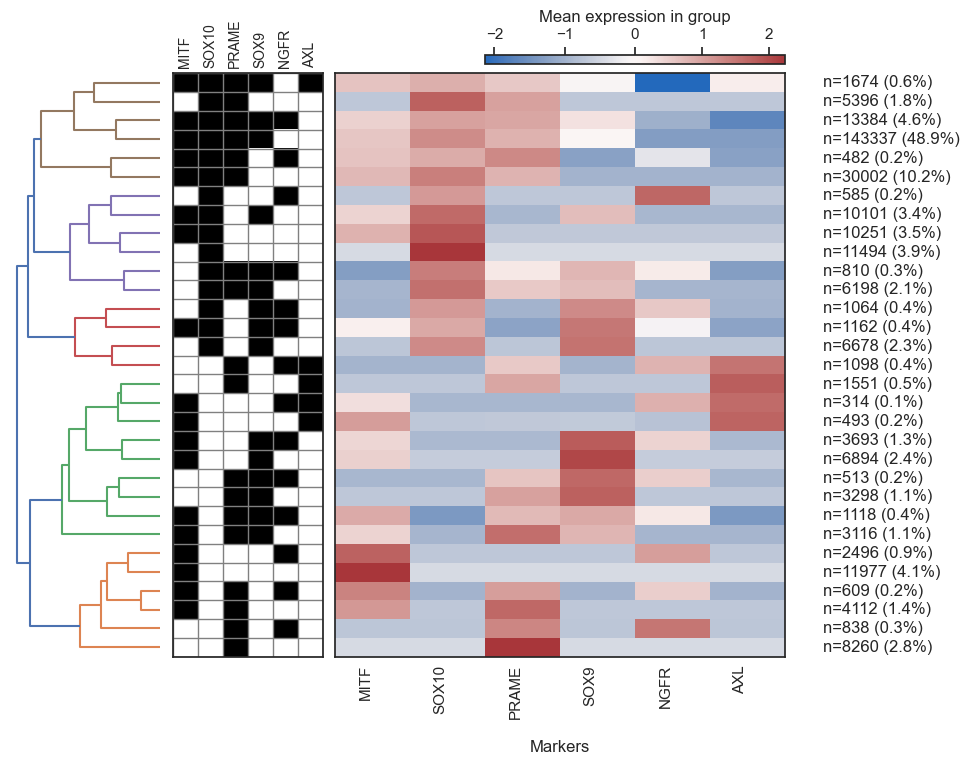

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  131945
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   24926
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   12295
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-    8992
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-    8836
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-    8424
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-    7830
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    6129
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    5747
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    5710
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    5646
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    4334
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3102
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    2777
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    2652
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    2474
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2017
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1122
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1026
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-     992
MITF- SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



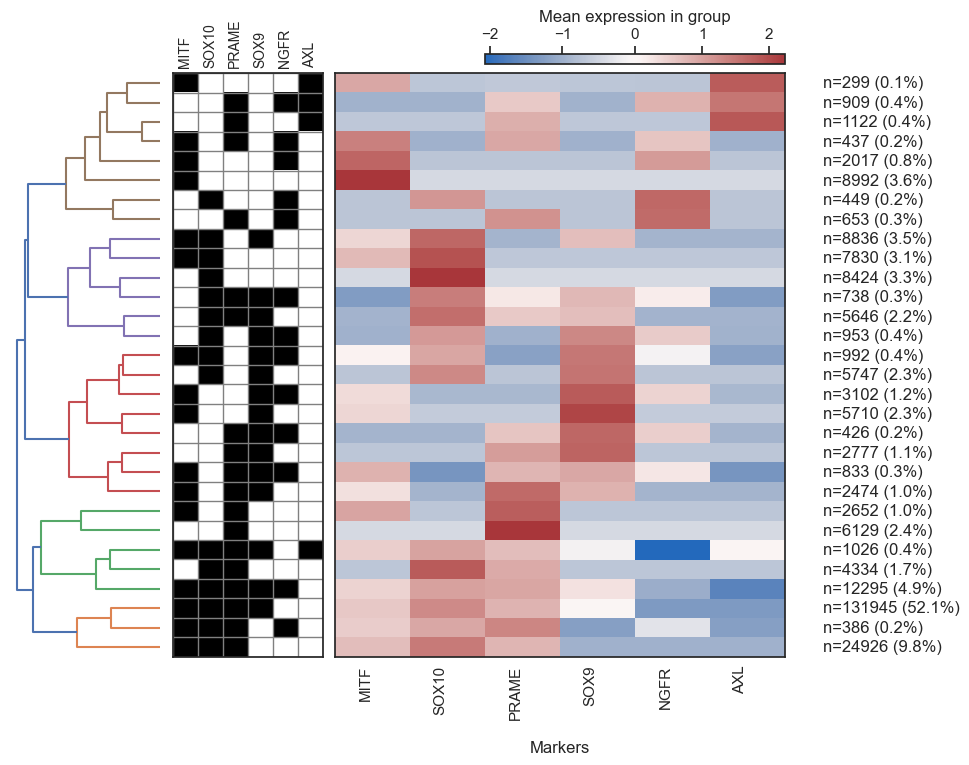

In [ ]:
for adata in adata_list[1:3]:
    imageid = adata.obs['imageid'].unique()[0]
    tumor_adata = adata[adata.obs['phenotype_category'] == 'Tumor']
    #tumor_adata.layers['log_background_normalized_zeroed_zscore']=stats.zscore(tumor_adata.layers["log_background_normalized_zeroed"], axis = 0)
    tumor_adata=hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001, verbose=True, return_adata=True)
    y_lab = f'Phenotypes in {imageid}'
    filename=f'AP-1_heatmap_{imageid}.png'
    phenotype_cross_cluster=hm.heatmapnew(
        tumor_adata,
        groupBy='phenotype',
        layer='log_background_normalized_zeroed',
        subsetMarkers=Diff_state_markers,
        
        clusterRows=True,
        clusterColumns=False,
        standardScale='column',
        showPrevalence=True,
        cmap='vlag',
        figsize=(10,10),
        scale_title=None,
        dend_threshold=4,
        dend_axis = False,
        y_lab='Categories',
        row_dendrogram=True,
        phenotype_matrix=True,
        phenotype_labels=Diff_state_markers,
        clustering_method='complete',
        verbose=True,
        return_row_linkage=True,
        #saveDir=os.path.join(project_dir, 'figures'),
        #fileName=filename
        )

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  143337
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   30002
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   13384
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-   11977
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-   11494
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-   10251
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-   10101
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    8260
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    6894
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    6678
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    6198
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    5396
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    4112
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3693
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    3298
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    3116
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2496
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1674
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1551
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-    1162
MITF+ SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



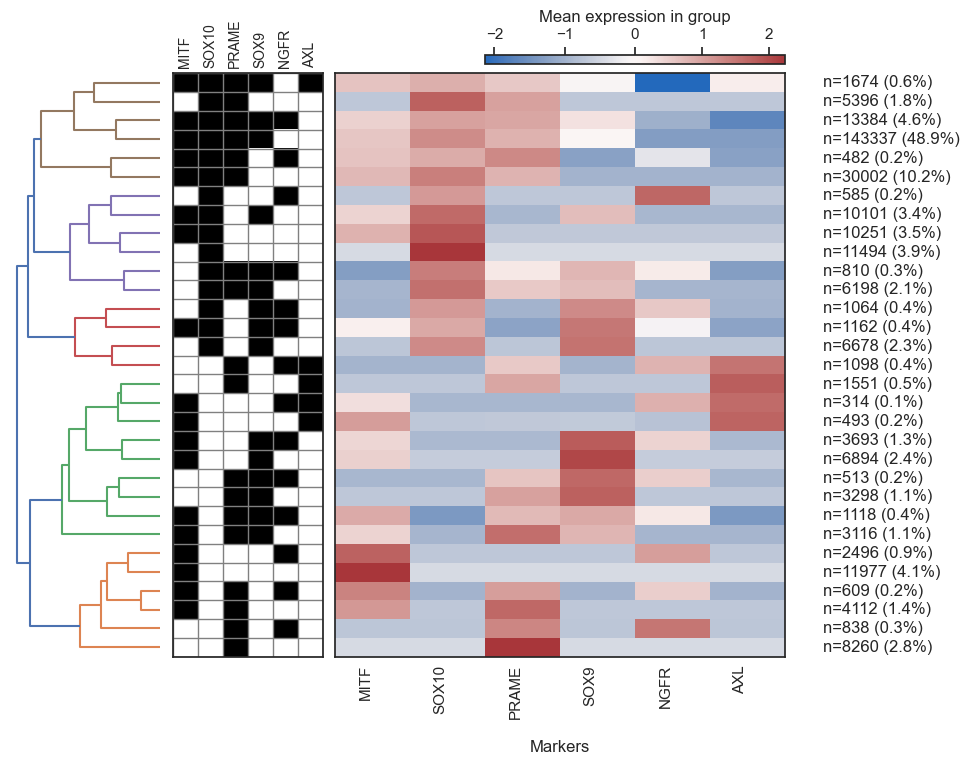

[[1 2 3 4 0 6]
 [0 2 3 0 0 0]
 [1 2 3 4 5 0]
 [1 2 3 4 0 0]
 [1 2 3 0 5 0]
 [1 2 3 0 0 0]
 [0 2 0 0 5 0]
 [1 2 0 4 0 0]
 [1 2 0 0 0 0]
 [0 2 0 0 0 0]
 [0 2 3 4 5 0]
 [0 2 3 4 0 0]
 [0 2 0 4 5 0]
 [1 2 0 4 5 0]
 [0 2 0 4 0 0]
 [0 0 3 0 5 6]
 [0 0 3 0 0 6]
 [1 0 0 0 5 6]
 [1 0 0 0 0 6]
 [1 0 0 4 5 0]
 [1 0 0 4 0 0]
 [0 0 3 4 5 0]
 [0 0 3 4 0 0]
 [1 0 3 4 5 0]
 [1 0 3 4 0 0]
 [1 0 0 0 5 0]
 [1 0 0 0 0 0]
 [1 0 3 0 5 0]
 [1 0 3 0 0 0]
 [0 0 3 0 5 0]
 [0 0 3 0 0 0]]
['MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+', 'MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-', 'MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-', 'MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-', 'MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL-', 'MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-', 'MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-', 'MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME- NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-', 'MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-', 'MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-', 'MITF+ SOX10+

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



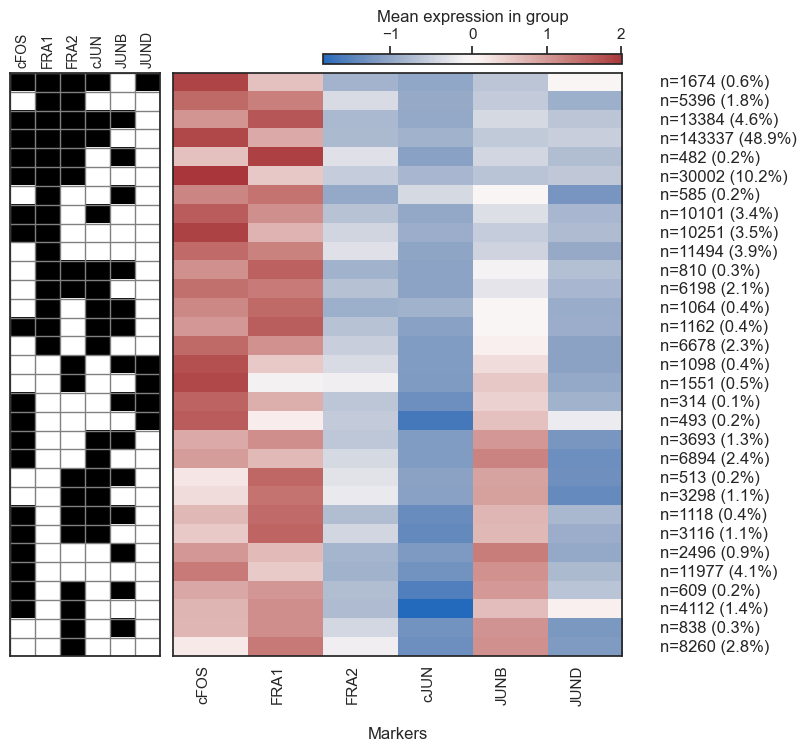

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  131945
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   24926
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   12295
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-    8992
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-    8836
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-    8424
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-    7830
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    6129
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    5747
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    5710
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    5646
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    4334
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3102
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    2777
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    2652
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    2474
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2017
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1122
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1026
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-     992
MITF- SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



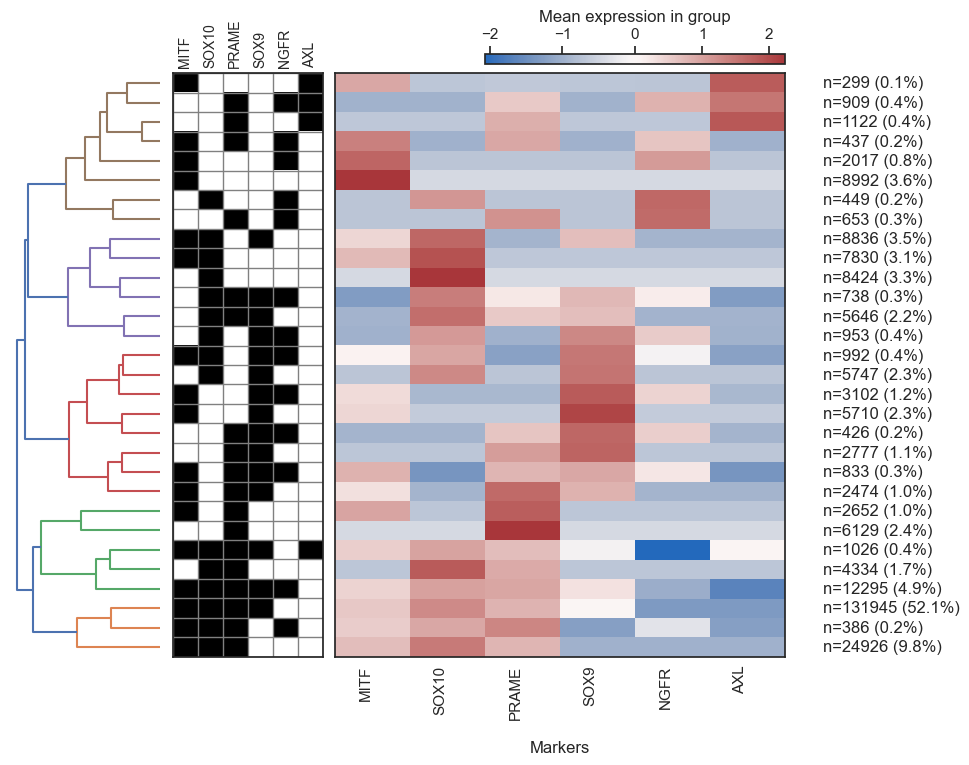

[[1 0 0 0 0 6]
 [0 0 3 0 5 6]
 [0 0 3 0 0 6]
 [1 0 3 0 5 0]
 [1 0 0 0 5 0]
 [1 0 0 0 0 0]
 [0 2 0 0 5 0]
 [0 0 3 0 5 0]
 [1 2 0 4 0 0]
 [1 2 0 0 0 0]
 [0 2 0 0 0 0]
 [0 2 3 4 5 0]
 [0 2 3 4 0 0]
 [0 2 0 4 5 0]
 [1 2 0 4 5 0]
 [0 2 0 4 0 0]
 [1 0 0 4 5 0]
 [1 0 0 4 0 0]
 [0 0 3 4 5 0]
 [0 0 3 4 0 0]
 [1 0 3 4 5 0]
 [1 0 3 4 0 0]
 [1 0 3 0 0 0]
 [0 0 3 0 0 0]
 [1 2 3 4 0 6]
 [0 2 3 0 0 0]
 [1 2 3 4 5 0]
 [1 2 3 4 0 0]
 [1 2 3 0 5 0]
 [1 2 3 0 0 0]]
['MITF+ SOX10- PRAME- NGFR- SOX9- AXL+', 'MITF- SOX10- PRAME+ NGFR+ SOX9- AXL+', 'MITF- SOX10- PRAME+ NGFR- SOX9- AXL+', 'MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL-', 'MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-', 'MITF+ SOX10- PRAME- NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-', 'MITF- SOX10- PRAME+ NGFR+ SOX9- AXL-', 'MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-', 'MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME- NGFR- SOX9- AXL-', 'MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-', 'MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-', 'MITF- SOX10+ PRAME- NGFR+ S

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



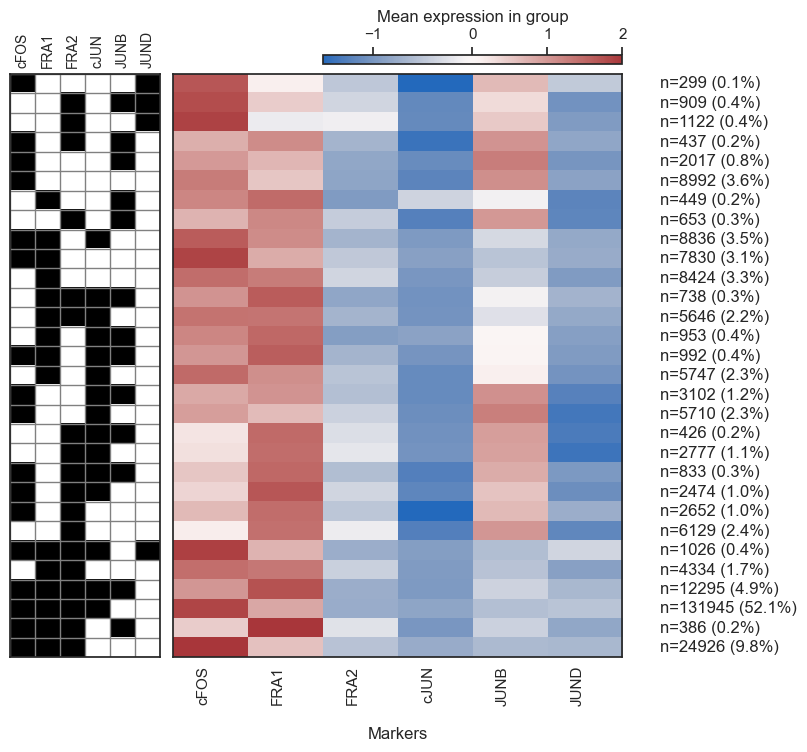

In [169]:
for adata in adata_list[1:3]:
    imageid = adata.obs['imageid'].unique()[0]
    tumor_adata = adata[adata.obs['phenotype_category'] == 'Tumor']
    tumor_adata = hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001, verbose=True, return_adata=True)
    y_lab = f'Phenotypes in {imageid}'
    filename = f'AP-1_heatmap_{imageid}.png'

    # Cluster rows using Diff_state_markers
    phenotype_cross_cluster = hm.heatmapnew(
        tumor_adata,
        groupBy='phenotype',
        layer='log_background_normalized_zeroed',
        subsetMarkers=Diff_state_markers,
        clusterRows=True,
        clusterColumns=False,
        standardScale='column',
        showPrevalence=True,
        cmap='vlag',
        figsize=(10, 10),
        scale_title=None,
        dend_threshold=4,
        dend_axis=False,
        y_lab='Categories',
        row_dendrogram=True,
        phenotype_matrix=True,
        phenotype_labels=Diff_state_markers,
        clustering_method='complete',
        verbose=True,
        return_row_linkage=True,
        #saveDir=os.path.join(project_dir, 'figures'),
        #fileName=filename
    )

    # Get row order from clustering result and reverse it
    row_order = list(phenotype_cross_cluster.keys())[::-1]

    # Generate AP1 heatmap with reversed row order from previous clustering
    hm.heatmapnew(
        tumor_adata,
        groupBy='phenotype',
        layer='log_background_normalized_zeroed',
        subsetMarkers=AP1s,
        clusterRows=False,  # Do not cluster rows, use manual order
        clusterColumns=False,
        standardScale='column',
        orderRow=row_order,
        showPrevalence=True,
        cmap='vlag',
        figsize=(10, 10),
        scale_title=None,
        dend_axis=False,
        y_lab='Categories',
        row_dendrogram=False,
        phenotype_matrix=True,
        phenotype_labels=AP1s,
        verbose=True,
        #saveDir=os.path.join(project_dir, 'figures'),
        #fileName=filename
    )

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  143337
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   30002
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   13384
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-   11977
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-   11494
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-   10251
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-   10101
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    8260
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    6894
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    6678
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    6198
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    5396
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    4112
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3693
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    3298
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    3116
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2496
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1674
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1551
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-    1162
MITF+ SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



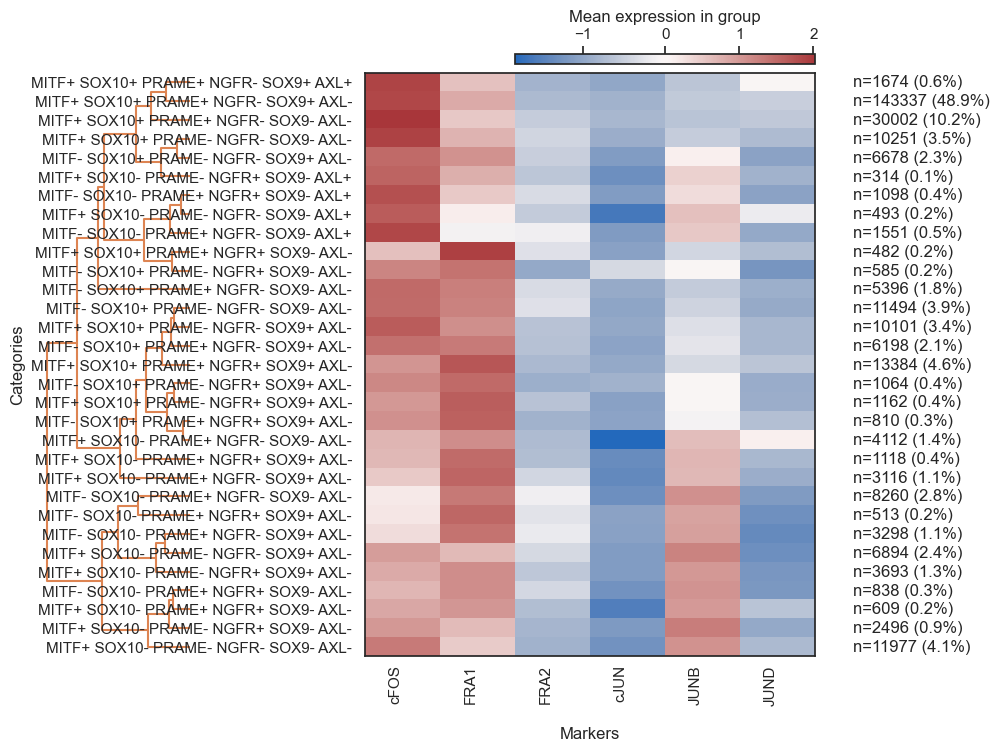

                                       count
phenotype                                   
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-  131945
MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-   24926
MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-   12295
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-    8992
MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-    8836
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-    8424
MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-    7830
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    6129
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    5747
MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-    5710
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    5646
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-    4334
MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-    3102
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    2777
MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-    2652
MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-    2474
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    2017
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    1122
MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL+    1026
MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-     992
MITF- SOX1

/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py:1621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



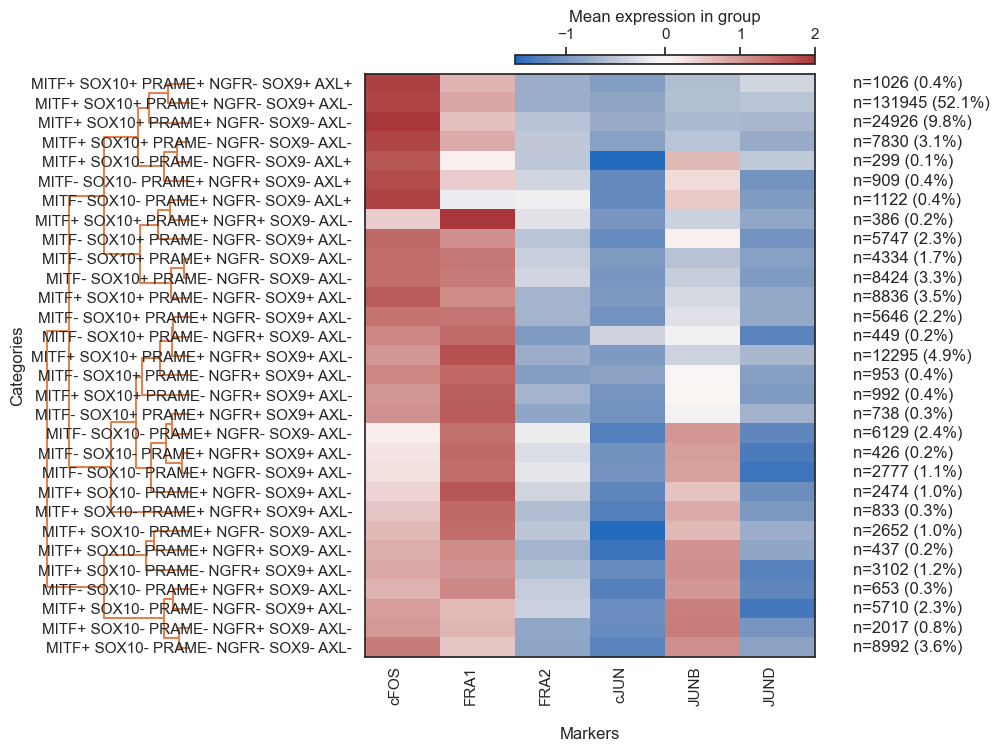

In [171]:
for adata in adata_list[1:3]:
    imageid = adata.obs['imageid'].unique()[0]
    tumor_adata = adata[adata.obs['phenotype_category'] == 'Tumor']
    #tumor_adata.layers['log_background_normalized_zeroed_zscore']=stats.zscore(tumor_adata.layers["log_background_normalized_zeroed"], axis = 0)
    tumor_adata=hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001, verbose=True, return_adata=True)
    y_lab = f'Phenotypes in {imageid}'
    filename=f'AP-1_heatmap_{imageid}.png'
    phenotype_cross_cluster=hm.heatmapnew(
        tumor_adata,
        groupBy='phenotype',
        layer='log_background_normalized_zeroed',
        subsetMarkers=AP1s,
        
        clusterRows=True,
        clusterColumns=False,
        standardScale='column',
        showPrevalence=True,
        cmap='vlag',
        figsize=(10,10),
        scale_title=None,
        dend_threshold=4,
        dend_axis = False,
        y_lab='Categories',
        row_dendrogram=True,
        #phenotype_matrix=True,
        #phenotype_labels=Diff_state_markers,
        clustering_method='complete',
        verbose=True,
        return_row_linkage=True,
        #saveDir=os.path.join(project_dir, 'figures'),
        #fileName=filename
        )

In [ ]:
hm.spatial_scatterPlot

In [181]:
def translate_matrix_to_phenotypes(matrix, markers, count=False):
    

    # Function to convert a row to phenotype string
    def row_to_phenotype(row, markers):
        phenotype = []
        for val, marker in zip(row, markers):
            if val == 0:
                phenotype.append(f"{marker}-")
            else:
                phenotype.append(f"{marker}+")
        return " ".join(phenotype)

    # Convert all rows in matrix to phenotype strings
    phenotype_array = [row_to_phenotype(row, markers) for row in matrix]

 
    if count == True:
        # Print counts for each repeating phenotype
        from collections import Counter
        counts = Counter(phenotype_array)
        print("\nPhenotype counts:")
        for pheno, count in counts.most_common():
            print(f"{pheno}: {count}")
    else:
           # Display the phenotype array
        return phenotype_array

In [ ]:
phenotype_counts =[]
for pheno in adata_subset.obs['phenotype'].unique():
    count = (adata_subset.obs['phenotype'] == pheno).sum()
    phenotype_counts.append({'phenotype': pheno, 'cell_count': count, 'percent_of_total_cells': (count/adata_subset.shape[0]) * 100},)
    
phenotype_count_df = pd.DataFrame(phenotype_counts)


In [186]:
phenotype_count_df

,phenotype,cell_count,percent_of_total_cells
0,MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-,19748,2.456619
1,MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-,37728,4.693302
2,MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-,66519,8.274856
3,MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-,17993,2.238300
4,MITF- SOX10+ PRAME- NGFR- SOX9- AXL-,36755,4.572262
5,MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-,21500,2.674565
6,MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL+,920,0.114447
7,MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-,250515,31.163660
8,MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-,37343,4.645409
9,MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-,2511,0.312364


In [ ]:
unique_matrix =

In [187]:
row_linkage = linkage(adata_subset, method='complete', metric='euclidean')
row_order = leaves_list(row_linkage)

KeyboardInterrupt: 

In [192]:
phenotype_cross_cluster 

{'MITF+ SOX10- PRAME- NGFR- SOX9- AXL-': 1,
 'MITF+ SOX10- PRAME- NGFR- SOX9+ AXL-': 1,
 'MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-': 1,
 'MITF+ SOX10- PRAME- NGFR+ SOX9+ AXL-': 1,
 'MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-': 1,
 'MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-': 1,
 'MITF+ SOX10+ PRAME- NGFR- SOX9- AXL-': 2,
 'MITF+ SOX10+ PRAME+ NGFR- SOX9- AXL-': 2,
 'MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-': 3,
 'MITF+ SOX10+ PRAME- NGFR- SOX9+ AXL-': 3,
 'MITF- SOX10+ PRAME- NGFR- SOX9- AXL-': 4,
 'MITF+ SOX10+ PRAME- NGFR+ SOX9+ AXL-': 4,
 'MITF+ SOX10+ PRAME+ NGFR+ SOX9+ AXL-': 4,
 'MITF+ SOX10+ PRAME+ NGFR- SOX9+ AXL-': 4,
 'MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL-': 5,
 'MITF+ SOX10+ PRAME+ NGFR+ SOX9- AXL-': 5,
 'MITF+ SOX10- PRAME+ NGFR+ SOX9- AXL-': 5,
 'MITF+ SOX10- PRAME+ NGFR+ SOX9+ AXL-': 5,
 'MITF+ SOX10- PRAME+ NGFR- SOX9- AXL-': 5,
 'MITF+ SOX10- PRAME+ NGFR- SOX9+ AXL-': 5,
 'MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-': 5,
 'MITF+ SOX10+ PRAME- NGFR+ SOX9- AXL-': 5,
 'MITF- SOX10+ PRAME- NGFR+ SOX9

In [191]:
row_order = leaves_list(phenotype_cross_cluster)

TypeError: Linkage matrix 'Z' must contain doubles.

In [194]:
adata_subset.obs["phenotype_cross_cluster"] = adata_subset.obs["phenotype"].map(phenotype_cross_cluster)

/var/folders/vb/f8_hhkls73qf5938jf5w6rk9dds1_2/T/ipykernel_27495/2162118479.py:1: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [195]:
adata_subset.obs['phenotype_cross_cluster'].value_counts()

phenotype_cross_cluster
4    483195
3    104247
1     90718
5     47583
2     41659
6     28808
7      7659
Name: count, dtype: int64

In [270]:
adata_list[10].uns['gates']

,Case11-13
markers,
AXL,3.960000
CD4,3.530000
CD45,3.270000
FRA1,5.000000
FRA2,3.710000
Hoechst,7.649927
JUNB,3.250000
JUND,3.230000
Ki67,3.130000


In [263]:
adata_list[7].uns['gates']=pd.read_csv(os.path.join( project_dir, 'Case9-7_R2', 'Case9-7_R2_gates.csv'),
        header = [0], index_col =[0])

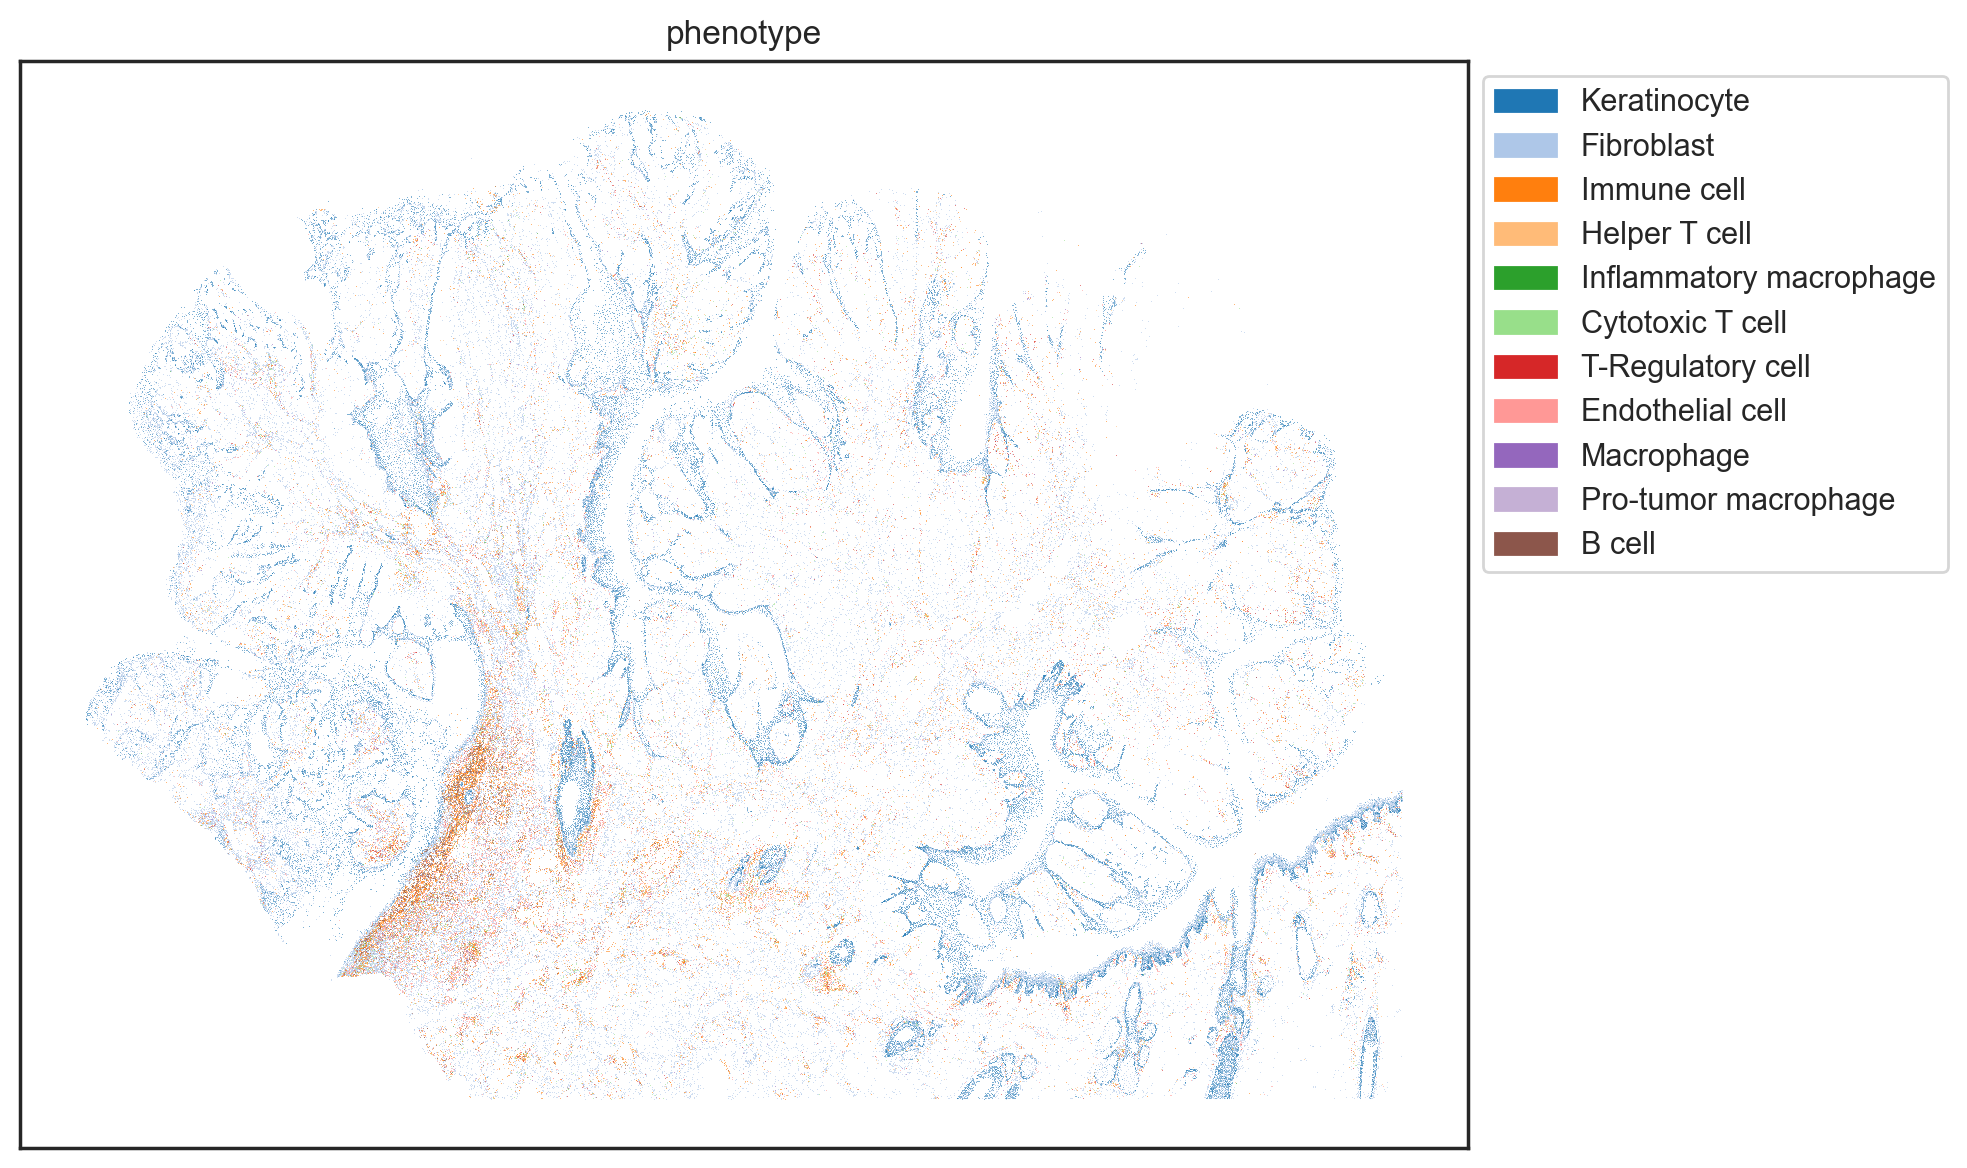

In [192]:
adata = adata_list[2]
tme_adata = adata[adata.obs['phenotype_category'] == 'TME']


hm.spatial_scatterPlot(
    tme_adata,
    colorBy='phenotype',
    figsize=(10,6),
)

In [269]:
adata_list[10].obs['imageid'].unique()

['Case11-13']
Categories (1, object): ['Case11-13']